In [22]:
import os
import sys
import numpy as np
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import geopandas as gpd
import rasterio 

from sklearn.metrics import r2_score 
from sklearn.linear_model import LinearRegression

import copy
from datetime import datetime
from datetime import date, timedelta
from scipy.stats import shapiro, ranksums, ttest_ind, ttest_rel, pearsonr, spearmanr
import copy
import seaborn as sns

sys.path.append('/home/r62/repos/russ_repos/Functions/')
sys.path.append('/home/r62/repos/russ_repos/river_ice_breakup/')

from STANDARD_FUNCTIONS import runcmd, create_directory, read_pickle, find_list_mismatch
from STATISTICS import summary_statistics
from REMOTE_SENSING_FUNCTIONS import find_extraction_coordinates
from TIME import create_list_of_dates
from RIVER_ICE_FUNCTIONS import get_missing_years
from VISUALIZATION_FUNCTIONS import Color_Palettes

AR_COLOR = 'deepskyblue'
PRECIP_COLOR = 'blue'
INFLUENCE_FUNCTION_COLOR = 'coral'
ROUND_TO = 2
OTHER_PLOTS_COLOR = 'orchid'

# Functions

In [23]:
def generate_leap_years(start = 0, end = 3000):
    leap_years = []
    for year in range(start, end+1):
        if (year % 4 == 0 and year % 100 != 0) or (year % 400 == 0):
            leap_years.append(year)
    return leap_years

def date_from_day_of_year(year, day_of_year):
    # Create a datetime object for January 1st of the given year
    base_date = datetime(year, 1, 1)
    # Add the number of days to the base date
    target_date = base_date + timedelta(days=day_of_year - 1)  # Subtract 1 because day_of_year is 1-based
    return target_date

def create_datetime_index(df, year_col_name, day_of_year_col_name, new_index_name='Date_IDX', drop=False):
    
    df[new_index_name] = df.apply(lambda row: date_from_day_of_year(int(row[year_col_name]), int(row[day_of_year_col_name])), axis=1)
    df[new_index_name] = pd.to_datetime(df[new_index_name], format='%Y-%m-%d')
    df.set_index(new_index_name, inplace=True)
    df.index = pd.to_datetime(df.index)
    if drop:
        df.drop(columns=[year_col_name, day_of_year_col_name], inplace=True, axis = 1)
    
    return df

def add_missing_day(df, missing_month_day, aggregation_method = 'mean'):

    DF = copy.copy(daymet_data)
    missing_month = missing_month_day[0]
    missing_day = missing_month_day[1]

    years = DF.index.year.unique()

    for year in years:
        if datetime(year, missing_month, missing_day) in DF[DF.index.year == year].index:
            pass
        else:
            before = np.array(DF.loc[datetime(year, missing_month, missing_day) - timedelta(days=1)])
            after = np.array(DF.loc[datetime(year, missing_month, missing_day) + timedelta(days=1)])
            before_after = np.stack([before, after])

            if aggregation_method.upper() == 'MEAN':
                new_row = np.nanmean(before_after, axis = 0)

            elif aggregation_method.upper() == 'MAX':
                new_row = np.nanmax(before_after, axis = 0)

            elif aggregation_method.upper() == 'MIN':
                new_row = np.nanmin(before_after, axis = 0)

            DF.loc[datetime(year, missing_month, missing_day)] = new_row

    DF.sort_index(ascending=True, inplace = True)
    return DF

            
class Convert_coordinates():
    
    def __init__(self, arr):
        self.arr = np.array(arr)
        
    def convert_to_positive_scale(self):
        return self.arr % 360

    def convert_to_negative_scale(self):
        return ((self.arr - 180) % 360) - 180

def record_missing_years(df):
    missing_years = []
    for yr in df.groupby(df.index.year):
        yr_df = yr[1]
        if yr_df['Boolean_Breakup'].sum() == 0:
            missing_years.append(yr[0])
        else:
            pass
    return missing_years

def get_kivt(ar_dataset, lat_index, lon_index):
    
    # retrieving kivt data from ar_dataset
    kivtx = np.squeeze(ar_dataset['kivtx'].to_numpy())
    kivty = np.squeeze(ar_dataset['kivty'].to_numpy())
    kivt = np.sqrt((kivtx**2) + (kivty**2))
    del kivtx, kivty

    shapemap = np.squeeze(ar_dataset['shapemap'].to_numpy())
    shapemap = shapemap[:, lat_index, lon_index]

    shapemap[np.isnan(shapemap)] = 0.0

    vals = []
    for idx, i in enumerate(shapemap):
        # subtracting 1 fixes the problem but I'm not 100% sure if its correct
        x = kivt[idx, int(i)-1]
        vals.append(x)

    vals = np.array(vals)
    vals[np.isnan(vals)] = 0.0
    
    return vals


def does_ar_happen_before_breakup(df, window):
    
    breakup_indices = df[df['Boolean_Breakup'] == 1].index
    mask = []
    IVT_data = []
    
    for i in breakup_indices:
        start = i - pd.Timedelta(days = window)
        ar_result = np.array(df.loc[start:i, 'KIVT'])

        if ar_result.sum() > 0:
            mask.append(1)
            IVT_data.append(np.array(df.loc[start:i, 'KIVT']).sum())

        else:
            mask.append(0)
            IVT_data.append(0.0)

    mask = np.array(mask).astype('bool')
    IVT_data = np.array(IVT_data)

    return IVT_data, mask

## Importing Breakup and location datasets

In [24]:
daymet_directory = '/mnt/locutus/remotesensing/r62/river_ice_breakup/Daymet_25_locations'
break_up_data = pd.read_pickle('/mnt/locutus/remotesensing/r62/river_ice_breakup/Breakup_Data/01_BREAK_UP_DATA_WEBSCRAPED.pkl')
locations_data = pd.read_csv('/mnt/locutus/remotesensing/r62/river_ice_breakup/Breakup_Data/CMIP6_analysis/Locations_Meta_Data_40_Sites.csv')
locations_data

,Site,Number of Breakup Events,River,Latitude,Longitude
0,Akiak,57,Kuskokwim River,60.912732,-161.211508
1,Alakanuk,38,Yukon River,62.668393,-164.621669
2,Allakaket,57,Koyukuk River,66.566503,-152.650150
3,Ambler,41,Kobuk River,67.092577,-157.835430
4,Aniak,48,Kuskokwim River,61.587542,-159.540806
5,Anvik,53,Yukon River,62.649764,-160.168864
6,Beaver,42,Yukon River,66.353426,-147.416190
7,Bethel,95,Kuskokwim River,60.765796,-161.749441
8,Bettles,70,Koyukuk River,66.921647,-151.528502
9,Circle,71,Yukon River,65.816790,-144.027390


### Seeing how many total unique sites/rivers there are

In [4]:
number_of_unique_locations = []
for i in break_up_data.groupby(['River', 'Location']):
    number_of_unique_locations.append(i[0])
    
print('NUMBER OF UNIQUE LOCATIONS:', len(number_of_unique_locations))
print('NUMBER OF UNIQUE RIVERS:', np.unique(np.array(break_up_data['River'])).shape[0])

NUMBER OF UNIQUE LOCATIONS: 96
NUMBER OF UNIQUE RIVERS: 55


### The one time it happened in February

In [16]:
break_up_data[break_up_data['Breakup Date'].dt.month == 2]

,River,Location,Year,Breakup Date,Site
485,Cook Inlet,Anchorage,1917,1917-02-21,Anchorage Cook Inlet


### Creating new Daymet Dataset

In [65]:
min_sites_to_consider = 35
daymet_max_locations = break_up_data[(break_up_data.Year >= 1980)]
daymet_max_locations = daymet_max_locations[daymet_max_locations.groupby('Site')['Site'].transform('count').gt(min_sites_to_consider)]
print('NUMBER OF SITES THAT FIT REQUIREMENTS:', daymet_max_locations.Site.unique().shape[0])

NUMBER OF SITES THAT FIT REQUIREMENTS: 25


## Creating a new plot for how I picked number of locations

In [31]:
# this section finds the best locations for the Daymet datasets

minimum_number_of_dates = 20 # lowest number of breakup events I will consider for evaluation
start_year = 1980 # Start of Daymet there are 43 years from 1980 till 2023
end_year = 2023

rng = range(minimum_number_of_dates, (end_year-start_year)+1, 1) # there are 43 years from 1980 till 2023:
number_of_breakup_events = []

for r in rng:
    dfs = []
    for site in break_up_data.groupby(['Location', 'River']):
        DF = site[1]
        DF.sort_values(by = 'Year', inplace=True)
        full_time_series = np.arange(DF.Year.min(), DF.Year.max()+1)
        missing = find_list_mismatch(full_time_series, np.array(DF['Year']))
        if len(DF[DF.Year >= start_year]) > r: 
            dfs.append(DF)
    try:
        df_most_data = pd.concat(dfs)
        df_most_data.reset_index(inplace=True, drop=True)
        summary_table = get_missing_years(df_most_data)

        number_of_breakup_events.append(summary_table.shape[0])
    except Exception:
        print('REACHED THE END')

dfs = []
optimal_number = 35 # 35 years with breakup events is determined below
for site in break_up_data.groupby(['Location', 'River']):
    DF = site[1]
    DF.sort_values(by = 'Year', inplace=True)
    full_time_series = np.arange(DF.Year.min(), DF.Year.max()+1)
    missing = find_list_mismatch(full_time_series, np.array(DF['Year']))
    if len(DF[DF.Year >= start_year]) > optimal_number:
        dfs.append(DF)

df_most_data = pd.concat(dfs)
df_most_data.reset_index(inplace=True, drop=True)
summary_table = get_missing_years(df_most_data)

REACHED THE END


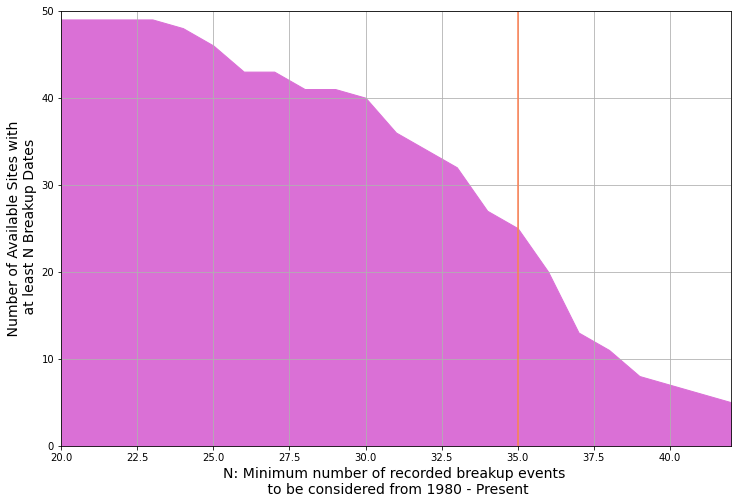

In [49]:
fontsize = 14

fig, axs = plt.subplots(nrows=1, ncols=1, figsize = (12, 8))
plt.subplots_adjust(hspace=0.25)

axs.fill_between(x = np.arange(minimum_number_of_dates, end_year-start_year),
                 y1 = number_of_breakup_events,
                 color = OTHER_PLOTS_COLOR)

axs.set_xlabel(f'N: Minimum number of recorded breakup events \n to be considered from {start_year} - Present',
               fontsize = fontsize)
axs.set_ylabel(' Number of Available Sites with \n at least N Breakup Dates',
               fontsize = fontsize)
axs.axvline(optimal_number,
               color = 'coral',
               linestyle = 'solid')
axs.set_xlim((minimum_number_of_dates, (end_year-start_year)-1))
axs.set_ylim((0, 50))
axs.grid()

# Insert location and river to try here!

In [25]:
SITE = 'Crooked_Creek'
RIVER = 'Kuskokwim'
WINDOW = 7
INCORPORATE_DAYMET = True

# Importing the AR dataset
ar_dataset = xr.open_dataset('/mnt/locutus/remotesensing/r62/river_ice_breakup/atmospheric_rivers/NCEP-NCAR/globalARcatalog_NCEP-NCAR_1948-2021_v3.0.nc')
print('IVT units:', ar_dataset['ivtx'].units)

IVT units: kg m^-1 s^-1


### Importing Daymet Data

In [26]:
if INCORPORATE_DAYMET:
    if os.path.exists(f'{daymet_directory}/{SITE}_{RIVER}_River.pkl'):
        print('DAYMET DATA AVAILABLE')
        daymet_data = pd.read_pickle(f'{daymet_directory}/{SITE}_{RIVER}_River.pkl')
        
        # make sure the calendars agree
        # Daymet reads in with 365 days/year (no leap years)
        daymet_data = pd.read_pickle(f'{daymet_directory}/{SITE}_{RIVER}_River.pkl')
        # create a datetime index using the year and yday columns
        daymet_data = create_datetime_index(daymet_data, 'year', 'yday', 'Date_IDX', True)
        # Since Daymet only goes to the 365 day of the year last day of the year is missing
        # this code will impute it!
        daymet_data = add_missing_day(daymet_data, (12, 31), aggregation_method = 'mean')
        # create a list of calendar dates from 1980-01-01 to 2022-12-31
        # and compare to this new index:
        daymet_dates_list = create_list_of_dates(date(1980, 1, 1), date(2022, 12, 31))
        print('DOES DAYMET DATETIME INDEX HAVE ALL DATES NO LEAP YEAR DAYS MISSING:')
        print(all(daymet_data.index == pd.to_datetime(daymet_dates_list)))

    else:
        print('DAYMET DATA NOT AVAILABLE')
        INCORPORATE_DAYMET = False
        
# separating out site information
location_info = locations_data[(locations_data.Site == SITE.replace('_', ' ')) & (locations_data.River == f'{RIVER} River')]
display(location_info)

lat = float(location_info.Latitude)
lon = float(location_info.Longitude)

lon, lat, _, _ = find_extraction_coordinates(ar_dataset, [lon % 360, lat, lon % 360, lat], 0)
lat_index = np.where(ar_dataset.lat.to_numpy() == lat)[0][0]
lon_index = np.where(ar_dataset.lon.to_numpy() == lon)[0][0]

# extracting shape variable data from our lat lon coordinates:
shapemap = np.squeeze(ar_dataset['shapemap'].to_numpy())
shapemap = shapemap[:, lat_index, lon_index]

# extracting IVT from AR dataset using lat lon from location in question:
kivt = get_kivt(ar_dataset=ar_dataset, lat_index=lat_index, lon_index=lon_index)

DAYMET DATA AVAILABLE
DOES DAYMET DATETIME INDEX HAVE ALL DATES NO LEAP YEAR DAYS MISSING:
True


,Site,Number of Breakup Events,River,Latitude,Longitude
10,Crooked Creek,56,Kuskokwim River,61.86593,-158.117206


In [27]:
# an example where T1 (188) is equal to a an AR LAT = 10
# shapemap[188]

SITE_spaces = SITE.replace('_', ' ')

# Bringing in the data from the river location in question
site_breakups = break_up_data[break_up_data.Site == f'{SITE_spaces} {RIVER} River']
site_breakups = site_breakups[(site_breakups.Year >= 1948) & (site_breakups.Year < 2022)]

# aggregate the kivt data since it was given in 6 hour intervals not daily
kivt_agg = np.nanmax(kivt.reshape(-1, 4), axis = 1)

# Create corresponding time axis given the start and end dates of the ar_dataset
list_of_dates = create_list_of_dates(date(1948, 1, 1), date(2021, 12, 31))

# notice they are now the same length
print('DO THE TIME ARRAY LENGTHS AGREE?', len(list_of_dates) == len(kivt_agg))

df = pd.DataFrame()

# Creating date information
df.index = list_of_dates
df.index = pd.to_datetime(df.index)
df['day_of_year'] = df.index.dayofyear

kivt_agg[np.isnan(kivt_agg)] = 0
df['KIVT'] = kivt_agg
df['KIVT'] = df['KIVT'].astype('float32')

df['Boolean_Breakup'] = 0
df.loc[np.array(site_breakups['Breakup Date']), 'Boolean_Breakup'] = 1
df['Boolean_Breakup'] = df['Boolean_Breakup'].astype('int16')

# removind KIVT data from the missing years
missing_years = record_missing_years(df)
df.loc[df.index.year.isin(missing_years), 'KIVT'] = 0.0
# add the daymet information if you wish!
# if daymet is not downloaded for this location this step does nothing:
if INCORPORATE_DAYMET:
    df = pd.merge(df, daymet_data, left_index=True, right_index=True)
    # day of year must be reset since daymet data is slightly off due to leap years:
    df['day_of_year'] = df.index.dayofyear

# Creating the IVT data
IVT_data, mask = does_ar_happen_before_breakup(df, WINDOW)

DO THE TIME ARRAY LENGTHS AGREE? True


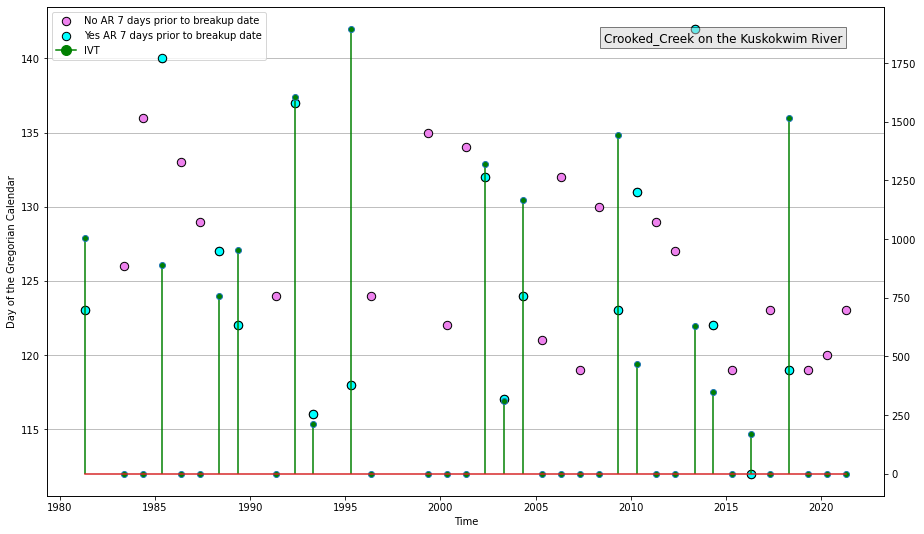

In [7]:
fig, axs = plt.subplots(figsize=(15, 9))

all_74_breakup_dates = df[df['Boolean_Breakup'] == 1].index
all_74_breakup_doys = df[df['Boolean_Breakup'] == 1]['day_of_year']

# Scatter plot for No AR
no_ar_scatter = axs.scatter(all_74_breakup_dates, 
                            all_74_breakup_doys,
                            zorder=5,
                            color='violet',
                            s=70,
                            edgecolor='black',
                            label=f'No AR {WINDOW} days prior to breakup date')

# Scatter plot for Yes AR
yes_ar_scatter = axs.scatter(all_74_breakup_dates[mask], 
                             all_74_breakup_doys[mask],
                             zorder=10,
                             color='cyan',
                             s=70,
                             edgecolor='black',
                             label=f'Yes AR {WINDOW} days prior to breakup date')

# Stem plot for IVT
axs2 = axs.twinx()

# if INCORPORATE_DAYMET:
#     temp_min = np.nanmin(df.loc[all_74_breakup_dates]['tmin (deg c)'].values)
#     temp_max = np.nanmax(df.loc[all_74_breakup_dates]['tmax (deg c)'].values)
#     daily_min = (df.loc[all_74_breakup_dates]['tmin (deg c)'].values - temp_min) / (temp_max - temp_min)
#     daily_max = (df.loc[all_74_breakup_dates]['tmax (deg c)'].values - temp_min) / (temp_max - temp_min)
    
#     axs2.fill_between(x=all_74_breakup_dates, y1=daily_min, y2=daily_max, color='coral', alpha = 0.35, zorder = 1)
#     IVT_data = (IVT_data - np.nanmin(IVT_data))/ (np.nanmax(IVT_data) - np.nanmin(IVT_data))

ivt_stem = axs2.stem(all_74_breakup_dates, IVT_data, linefmt='green', label='IVT')
markerline, stemlines, baseline = ivt_stem
markerline.set_markerfacecolor('green')

# Create custom legend handles for the stem plot
stem_legend_handle = plt.Line2D([], [], color='green', marker='o', markersize=10, label='IVT')

# Setting labels and legends
axs.set_ylabel('Day of the Gregorian Calendar')
axs.set_xlabel('Time')
axs.grid(axis='y')

# Combine legends
scatter_handles, scatter_labels = axs.get_legend_handles_labels()
axs.legend(scatter_handles + [stem_legend_handle], scatter_labels + ['IVT'], loc='upper left')

# Add location label:
text_box_content = f"{SITE} on the {RIVER} River"
plt.text(0.95, 0.95, text_box_content,
         fontsize=12,
         transform=axs.transAxes,
         verticalalignment='top',
         horizontalalignment='right',
         bbox=dict(facecolor='lightgray', alpha=0.5))

plt.show()

# Looking at aggregated IVT

In [8]:
aggregation_method = 'sum' # options are mean_zeros, mean_no_zeros, sum

aggregated_IVT, ns = [], []
for breakup_idx in df[df['Boolean_Breakup'] == 1].index:
    year = breakup_idx.year
    start_date = pd.to_datetime(f'{year}-02-01')
    DF = df[(df.index >= start_date) & (df.index <= breakup_idx)]
    DF_KIVT = np.array(DF['KIVT'])
    ns.append(DF_KIVT.astype('bool').sum())
    if aggregation_method.upper() == 'SUM':
        aggregated_IVT.append(np.sum(DF_KIVT))
    elif aggregation_method.upper() == 'MEAN_NO_ZEROS':
        DF_KIVT[DF_KIVT == 0] = np.nan 
        aggregated_IVT.append(np.nanmean(DF_KIVT))
    elif aggregation_method.upper() == 'MEAN_ZEROS':
        aggregated_IVT.append(np.nanmean(DF_KIVT))
        
aggregated_IVT = np.array(aggregated_IVT)
ns = np.array(ns)

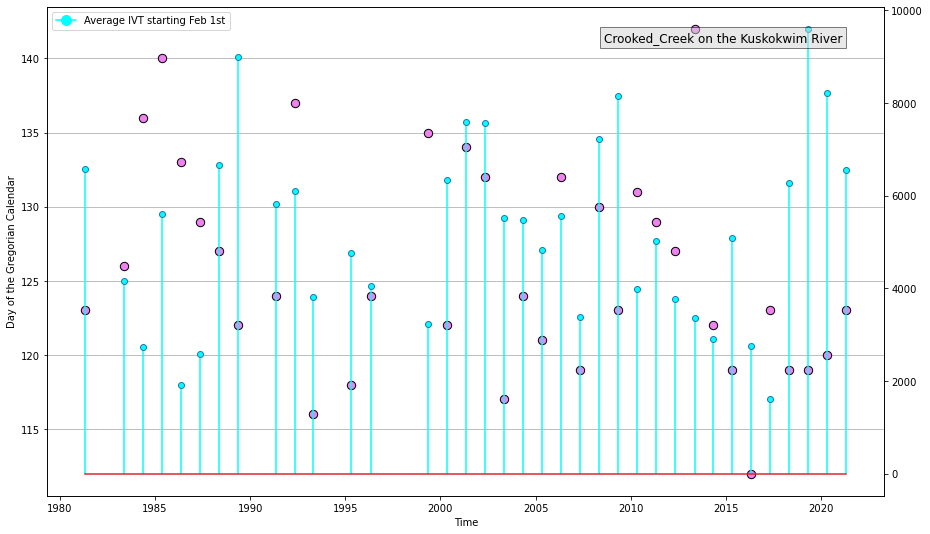

In [9]:
fig, axs = plt.subplots(figsize=(15, 9))

all_74_breakup_dates = df[df['Boolean_Breakup'] == 1].index
all_74_breakup_doys = df[df['Boolean_Breakup'] == 1]['day_of_year']

# Scatter plot for No AR
breakup_events = axs.scatter(all_74_breakup_dates, 
                            all_74_breakup_doys,
                            zorder=5,
                            color='violet',
                            s=70,
                            edgecolor='black')

# Stem plot for IVT
axs2 = axs.twinx()
ivt_stem = axs2.stem(all_74_breakup_dates, aggregated_IVT, linefmt='cyan')
markerline, stemlines, baseline = ivt_stem
markerline.set_markerfacecolor('cyan')

# Create custom legend handles for the stem plot
stem_legend_handle = plt.Line2D([], [], color='cyan', marker='o', markersize=10, label='Average IVT starting Feb 1st')

# Setting labels and legends
axs.set_ylabel('Day of the Gregorian Calendar')
axs.set_xlabel('Time')
axs.grid(axis='y')

# Combine legends
scatter_handles, scatter_labels = axs.get_legend_handles_labels()
axs.legend(scatter_handles + [stem_legend_handle], scatter_labels + ['Average IVT starting Feb 1st'], loc='upper left')

# Add location label:
text_box_content = f"{SITE} on the {RIVER} River"
plt.text(0.95, 0.95, text_box_content,
         fontsize=12,
         transform=axs.transAxes,
         verticalalignment='top',
         horizontalalignment='right',
         bbox=dict(facecolor='lightgray', alpha=0.5))

plt.show()

# Comparing Temperature Datasets as well as IVT and Precip

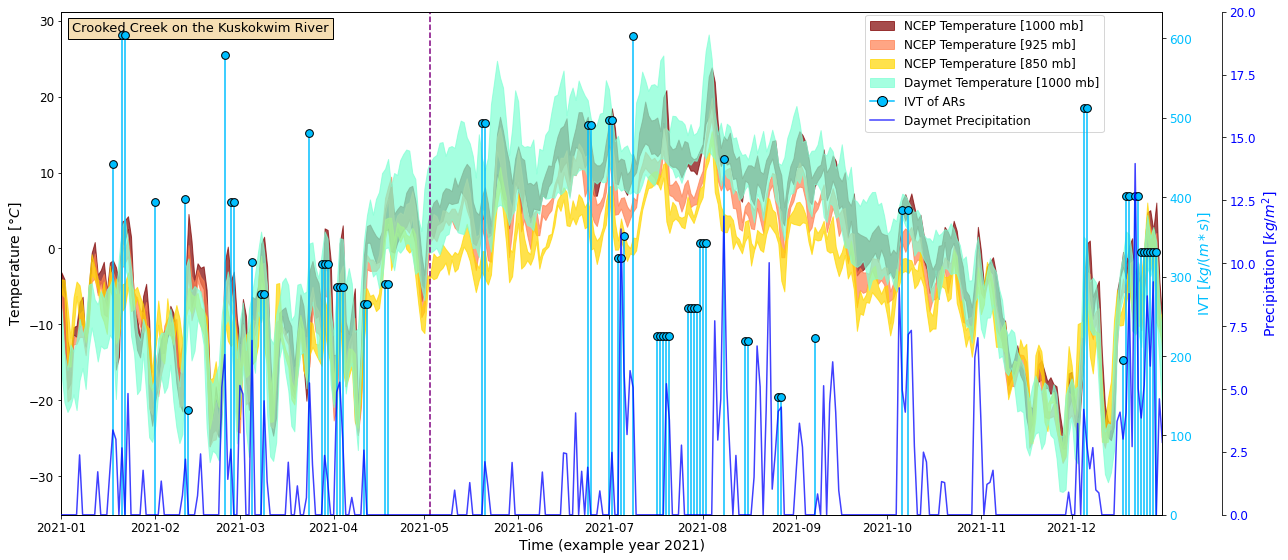

In [121]:
test_year = 2021
FONT_SIZE = 14
LEGEND = True
SAVE = True

# calculating the IVT vars
IVT_idx = df.loc[(df.index.year == test_year) & (df['KIVT'] != 0)].index
IVT_time_series = df.loc[(df.index.year == test_year) & (df['KIVT'] != 0)]['KIVT']

# Example download:
# wget https://psl.noaa.gov/thredds/fileServer/Datasets/ncep.reanalysis2/pressure/air.2002.nc
ncep_ds = xr.open_dataset(f'/mnt/locutus/remotesensing/r62/river_ice_breakup/atmospheric_rivers/NCEP_Temp_data/air.{test_year}.nc')

ncep_lat_index = np.where(ncep_ds['lat'].values == lat)[0][0]
ncep_lon_index = np.where(ncep_ds['lon'].values == lon)[0][0]

ncep_temp = ncep_ds.isel(lat=ncep_lat_index, lon=ncep_lon_index)['air'].to_numpy()

temp_1000 = ncep_temp[:, 0] - 273.15
temp_925 = ncep_temp[:, 1] - 273.15
temp_850 = ncep_temp[:, 2] - 273.15

temp_1000_min = np.min(temp_1000.reshape(-1, 4), axis = 1)
temp_925_min = np.min(temp_925.reshape(-1, 4), axis = 1)
temp_850_min = np.min(temp_850.reshape(-1, 4), axis = 1)

temp_1000_max = np.max(temp_1000.reshape(-1, 4), axis = 1)
temp_925_max = np.max(temp_925.reshape(-1, 4), axis = 1)
temp_850_max = np.max(temp_850.reshape(-1, 4), axis = 1)

temp_1000_mean = np.mean(temp_1000.reshape(-1, 4), axis = 1)
temp_925_mean = np.mean(temp_925.reshape(-1, 4), axis = 1)
temp_850_mean = np.mean(temp_850.reshape(-1, 4), axis = 1)

INDEX = daymet_data[daymet_data.index.year == test_year].index
daymet_tmin = np.array(daymet_data[daymet_data.index.year == test_year]['tmin (deg c)'])
daymet_tmax = np.array(daymet_data[daymet_data.index.year == test_year]['tmax (deg c)'])
daymet_precip = np.array(daymet_data[daymet_data.index.year == test_year]['prcp (mm/day)'])

fig, axs = plt.subplots(figsize=(18, 8))
axs.set_facecolor('white')
# axs.grid()

axs.fill_between(INDEX, temp_1000_min, temp_1000_max, color = 'maroon', label = 'NCEP Temperature [1000 mb]', alpha = 0.7)
axs.fill_between(INDEX, temp_925_min, temp_925_max, color = 'coral', label = 'NCEP Temperature [925 mb]', alpha = 0.7)
axs.fill_between(INDEX, temp_850_min, temp_850_max, color = 'gold', label = 'NCEP Temperature [850 mb]', alpha = 0.7)
axs.fill_between(INDEX, daymet_tmin, daymet_tmax, color = 'aquamarine', label = 'Daymet Temperature [1000 mb]', alpha = 0.7)
axs.set_ylabel(f'Temperature $[\u00b0C]$', fontsize = FONT_SIZE)
axs.set_xlabel(f'Time (example year {test_year})', fontsize = FONT_SIZE)
axs.tick_params(axis='y', labelsize=FONT_SIZE-2)
axs.tick_params(axis='x', labelsize=FONT_SIZE-2)

# Add location label:
text_box_content = f"{SITE_spaces} on the {RIVER} River"
plt.text(0.01, 0.98, text_box_content,
         fontsize=FONT_SIZE-1,
         transform=axs.transAxes,
         verticalalignment='top',
         horizontalalignment='left',
         bbox=dict(facecolor='wheat', alpha=1.0))

axs2 = axs.twinx()
axs2.set_ylabel('IVT ' + r'$[kg/(m*s)]$',
                fontsize = FONT_SIZE,
                color = AR_COLOR)

axs2.tick_params(axis='y', labelcolor=AR_COLOR, labelsize=FONT_SIZE-2)

markerline, stemlines, baseline = axs2.stem(IVT_idx,
                                            IVT_time_series,
                                            linefmt=AR_COLOR,
                                            label = 'IVT of ARs',
                                            basefmt=' ',
                                            markerfmt='oc')
stemlines.set_zorder(30)
baseline.set_zorder(0)

axs2.scatter(IVT_idx,
             IVT_time_series,
             edgecolor = 'black',
             color = AR_COLOR,
             s = 60,
             zorder = 30)

markerline.set_markerfacecolor(AR_COLOR)

# Customize the appearance of the stem plot
plt.setp(stemlines, color=AR_COLOR)
plt.setp(markerline, color=AR_COLOR)
plt.setp(baseline, visible=False)

# Define a custom legend handle
custom_legend_handle = Line2D([0], [0], marker='o', color=AR_COLOR, markersize=10, linestyle='-', markerfacecolor=AR_COLOR, markeredgecolor = 'black')

if df[(df.index.year == test_year) & (df['Boolean_Breakup'] == 1)].shape[0] != 0:
    axs.axvline(x=df[(df.index.year == test_year) & (df['Boolean_Breakup'] == 1)].index[0], color='purple', linestyle='--')

# Add a third y-axis (ax3) that shares the same x-axis
axs3 = axs.twinx()

# Move the third y-axis to the right side of the plot
# Set the position of the third y-axis outward by 60 points
axs3.spines['right'].set_position(('outward', 60))

# Plot data on the third y-axis (axs3)
axs3.plot(INDEX, daymet_precip, color = PRECIP_COLOR, label = 'Daymet Precipitation', alpha = 0.75, zorder = 10)
axs3.set_ylabel('Precipitation ' + r'$[kg/m^2]$', fontsize = FONT_SIZE, color = PRECIP_COLOR)
axs3.tick_params(axis='y', labelcolor=PRECIP_COLOR, labelsize=FONT_SIZE-2)

# This allows you to have twin axis and one legend
# Get handles and labels from both axes
handles1, labels1 = axs.get_legend_handles_labels()
handles2, labels2 = axs2.get_legend_handles_labels()
handles3, labels3 = axs3.get_legend_handles_labels()

handles2[0] = custom_legend_handle

# Combine handles and labels
handles = handles1 + handles2 + handles3
labels = labels1 + labels2 + labels3

if LEGEND:
    axs.legend(handles, labels, loc = (0.73, 0.76), fontsize = FONT_SIZE-2)
    
# set axis bounds
plt.xlim((INDEX.min(), INDEX.max()))
axs2.set_ylim((0, IVT_time_series.max()+30))
axs3.set_ylim((0, 20))

plt.tight_layout()

if SAVE:
    plt.savefig(f'/mnt/locutus/remotesensing/r62/river_ice_breakup/atmospheric_rivers/Results/images/{SITE}_on_the_{RIVER}_River_{test_year}_temp_AR_plot.png',
                dpi = 400,
                facecolor = 'white')
else:
    plt.show();

# Q = m*c*(delta T)

In [36]:
def apply_threshold_function(sub_df, temp_threshold):
    
    IVT_df = sub_df[(sub_df['KIVT'] != 0.0) & (sub_df['tmax (deg c)'] <= temp_threshold)]
    # t_values = np.arange(breakup_day_of_year)
    output = np.array(IVT_df['KIVT']* IVT_df['tmax (deg c)'] * 4186 * 86400)
    return output

def apply_exponential_influence_function(sub_df, scaling_factor, breakup_doy, center_of_bias_date, IVT_Precip, dampening_parameter=1000000000):
    
    center_bias_n = sub_df.loc[:center_of_bias_date].shape[0]
    t_values = np.arange(len(sub_df))
    t_values = t_values - center_bias_n
            
    right_t_values = t_values[t_values > 0]
    left_t_values = t_values[t_values <= 0]
    
    right_skew_func = ((np.exp(-1*scaling_factor*((right_t_values) - breakup_doy)))-1)/dampening_parameter
    left_skew_func = ((np.exp(-1*scaling_factor*(-1*(left_t_values) - breakup_doy)))-1)/dampening_parameter   
    
    func = np.concatenate([left_skew_func, right_skew_func])
    sub_df['func'] = func
    
    IVT_df = sub_df[sub_df[IVT_Precip] != 0.0]
    output = IVT_df.apply(lambda row: row['func'] * row[IVT_Precip] * row['tmin (deg c)'] * (4186 * 86400), axis=1)

    return output, func, sub_df.index

def apply_normal_influence_function(sub_df, center_of_bias_date, sigma):

    center_bias_n = sub_df.loc[:center_of_bias_date].shape[0]
    t_values = np.arange(len(sub_df))
    t_values = t_values - center_bias_n
    
    mu = 0
    sub_df['day_number'] = t_values
    
    # only want the days that have IVT
    IVT_df = sub_df[sub_df['KIVT'] != 0.0]
    
    # normal fuctions applied to days with IVT
    func = 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (t_values - mu)**2 / (2 * sigma**2))
    output = IVT_df.apply(lambda row: func[int(row['day_number'])] *
                          row['KIVT'] * (row['tmin (deg c)']) * (4186 * 86400), axis=1)
    
    return output, func, sub_df.index

def format_float(float_number, round_to = ROUND_TO, threshold = 0.05):
    if float_number >= threshold:
        return round(float_number, round_to)
    elif float_number < threshold:
        char_num = str(round_to)
        format_string = "{:." + char_num + "e}"
        return float(format_string.format(float_number))

In [117]:
PLOT = True
TUNE = False
aggregation_method = 'sum'
method = 'exponential'
start_date_previous_year_month_day = (9, 15) # where the df starts for the first date to allow for bias
CENTER_OF_BIAS_month_day = (3, 1) # BEST FOR CROOKED CREEK: (11, 26) the month then day of the center date of the bias function. This will later be mu
variable_measured = 'prcp (mm/day)' # 'prcp (mm/day)' 'KIVT'

# for the exponential method
SCALING_FACTOR = 0.16000000000000003

# for the normal method
SIGMA = 10

# for the threshold method
TEMP_THRESHOLD = -5.0

# hyperparameter tuning
scaling_factors = np.arange(0.06, 0.30+0.02, 0.02) # sigmas for normal distribution
sigmas = list(range(5, 25+5, 5))
center_of_biases = np.array([(11, 12), (11, 19), (11, 26), (12, 3), (12, 10),
                             (12, 17), (12, 24), (1, 1), (1, 8), (1, 15),
                             (1, 22), (1, 29), (2, 5), (2, 12)])

LOOKING AT VARIABLE: Precipitation
BEST PEARSON CORRELATION VALUE: -0.47
BEST HYPERPARAMETERS: 0.16 (3, 1)
aggregation method: sum


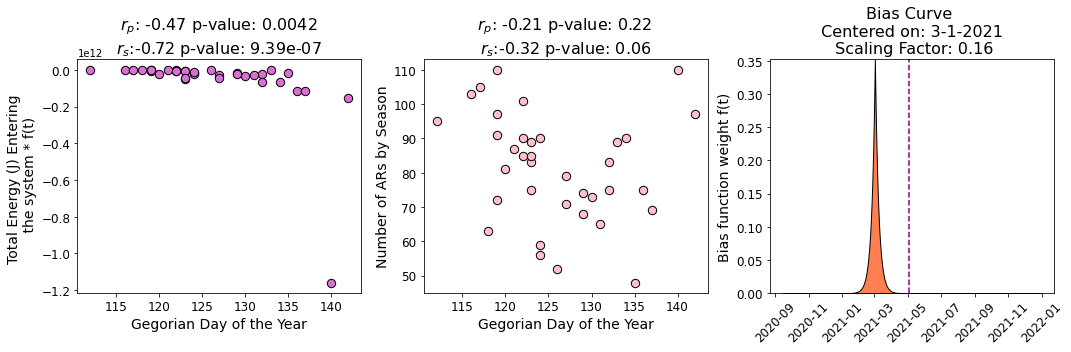

In [118]:
best_pearson_values = []
hp_space = []
fontsize = 14
REMOVE_TITLE = True

# for SIGMA in sigmas:
for scaling_factor in scaling_factors:
    for center_of_bias_month_day in center_of_biases:
        
        if TUNE == False:
            center_of_bias_month_day = CENTER_OF_BIAS_month_day
            scaling_factor = SCALING_FACTOR
            
        hp_space.append([scaling_factor, center_of_bias_month_day])
        
        years = np.array(df.index.year.unique())
        metrics, day_of_year, number_of_ARs_per_year, OUTPUTS, breakup_dates = [], [], [], [], []

        for idx, year in enumerate(years):
            if idx == 0:
                continue

            start_date = f'{year-1}-{start_date_previous_year_month_day[0]}-{start_date_previous_year_month_day[1]}'
            sub_df = df[df.index.year.isin([year-1, year])].loc[start_date:]

            if len(sub_df[sub_df['Boolean_Breakup'] == 1]) == 0:
                continue

            # breakup date as date and recording it for plots later
            breakup_index = sub_df[sub_df['Boolean_Breakup'] == 1].index[0]
            breakup_dates.append(breakup_index)

            # This says if the center of bias is greater than the month of the breakup
            # date, then we are centering the bias in the previous year
            if center_of_bias_month_day[0] > breakup_index.month:
                center_year = year - 1
            else:
                center_year = year

            # center of bias as a date
            center_of_bias_date = f'{center_year}-{center_of_bias_month_day[0]}-{center_of_bias_month_day[1]}'

            # Record the number of ARs for each year
            number_of_ARs = len(sub_df[sub_df['KIVT'] > 0.0])
            number_of_ARs_per_year.append(number_of_ARs)

            # Record the breakup doy for each year
            breakup_doy = breakup_index.timetuple().tm_yday
            day_of_year.append(breakup_doy)

            if method.upper() == 'EXPONENTIAL':
                ncols = 3
                output, func_values, func_dates = apply_exponential_influence_function(sub_df=sub_df,
                                                                                       scaling_factor=scaling_factor,
                                                                                       breakup_doy=breakup_doy,
                                                                                       IVT_Precip = variable_measured,
                                                                                       center_of_bias_date=center_of_bias_date)

            if method.upper() == 'NORMAL':
                ncols = 3
                mu = sub_df.index.get_loc(center_of_bias_date)
                output, func_values, func_dates = apply_normal_influence_function(sub_df,
                                                                            center_of_bias_date,
                                                                            SIGMA)

            elif method.upper() == 'THRESHOLD':
                ncols = 2
                output = apply_threshold_function(sub_df, temp_threshold)

            if aggregation_method.upper() == 'SUM':
                agg = output.sum()
                metrics.append(agg)
            elif aggregation_method.upper() == 'MEAN':
                agg = output.mean()
                metrics.append(agg)
            elif aggregation_method.upper() == 'MAX':
                agg = output.max()
                metrics.append(agg)

            OUTPUTS.append(output)

        metrics = np.array(metrics)
        number_of_ARs_per_year = np.array(number_of_ARs_per_year)
        day_of_year = np.array(day_of_year)

        pearson_metrics = pearsonr(day_of_year, metrics)
        spearman_metrics = spearmanr(day_of_year, metrics)

        best_pearson_values.append(pearson_metrics[0])

        if TUNE == False:
            break
    if TUNE == False:
        break

if variable_measured == 'prcp (mm/day)':
    var_name = 'Precipitation'

elif variable_measured == 'KIVT':
    var_name = 'Integrated Vapor Transport'
      
print('LOOKING AT VARIABLE:', var_name)

best_idx = np.argmax(np.abs(np.array(best_pearson_values)))
best_hps = hp_space[best_idx]
print('BEST PEARSON CORRELATION VALUE:', round(best_pearson_values[best_idx], ROUND_TO))
print('BEST HYPERPARAMETERS:', round(best_hps[0], ROUND_TO), best_hps[1]) 


if PLOT:
        
    print(f'aggregation method: {aggregation_method}')

    fig, axs = plt.subplots(nrows = 1, ncols = ncols, figsize = (15, 5))
    
    if REMOVE_TITLE:
        pass
    else:
        fig.suptitle(f'{SITE_spaces} on the {RIVER} River', fontsize = fontsize+8)
    
    pearson_metrics = pearsonr(day_of_year, metrics)
    spearman_metrics = spearmanr(day_of_year, metrics)
    
    pearson_n_ARs = pearsonr(day_of_year, number_of_ARs_per_year)
    spearman_n_ARs = spearmanr(day_of_year, number_of_ARs_per_year)
    
    pearson_AR_pvalue = format_float(pearson_metrics[1])
    spearman_AR_pvalue = format_float(spearman_metrics[1])
    pearson_n_AR_pvalue = format_float(pearson_n_ARs[1])
    spearman_n_AR_pvalue = format_float(spearman_n_ARs[1])
    
    axs1_title = r'$r_{p}$:' + f' {round(pearson_metrics[0], ROUND_TO)} p-value: {pearson_AR_pvalue} \n' + r'$r_{s}$:' + f'{round(spearman_metrics[0], ROUND_TO)} p-value: {spearman_AR_pvalue}'
    axs[0].set_title(axs1_title, fontsize = fontsize+2)

    axs[0].scatter(day_of_year,
                   metrics,
                   color = OTHER_PLOTS_COLOR,
                   s=70,
                   edgecolor = 'black')
    
    axs[0].set_xlabel('Gegorian Day of the Year', fontsize = fontsize)
    axs[0].tick_params(axis='x',
                       labelsize=fontsize-2)
        
    axs[0].set_ylabel(f'Total Energy (J) Entering \n the system * f(t)', fontsize = fontsize)
    axs[0].tick_params(axis='y',
                       labelsize=fontsize-2)
    axs2_title = r'$r_{p}$:' + f' {round(pearson_n_ARs[0], ROUND_TO)} p-value: {pearson_n_AR_pvalue} \n' + r'$r_{s}$:' + f'{round(spearman_n_ARs[0], ROUND_TO)} p-value: {spearman_n_AR_pvalue}'
    axs[1].set_title(axs2_title, fontsize = fontsize+2)

    axs[1].scatter(day_of_year,
                   number_of_ARs_per_year,
                   color = 'pink',
                   s=70,
                   edgecolor = 'black')
    
    axs[1].set_xlabel('Gegorian Day of the Year', fontsize = fontsize)
    axs[1].tick_params(axis='x',
                       labelsize=fontsize-2)
        
    axs[1].set_ylabel('Number of ARs by Season', fontsize = fontsize)
    axs[1].tick_params(axis='y',
                   labelsize=fontsize-2)
    if method.upper() == 'NORMAL':
        axs[2].set_title(f'Example of bias using {test_year} \n Temporal Bias center: {center_year}-{center_of_bias_month_day[0]}-{center_of_bias_month_day[1]}, sigma: {SIGMA} \n Method: {method}')

        axs[2].fill_between(func_dates, func_values, color = INFLUENCE_FUNCTION_COLOR, edgecolor = 'black')
        axs[2].axvline(x=breakup_index, color='purple', linestyle='--') # Show breakup date
        axs[2].set_xlabel('Time')
        axs[2].set_ylim((0, np.max(func_values)))
        axs[2].set_ylabel('Bias function weight f(t)')
        axs[2].grid()

    elif method.upper() == 'EXPONENTIAL':
        scaling_factor_rounded = round(scaling_factor, ROUND_TO)
        axs[2].tick_params(axis='x',
                           labelsize=fontsize-2,
                           labelrotation=45)
        
        axs[2].set_title(f'Bias Curve \n Centered on: {CENTER_OF_BIAS_month_day[0]}-{CENTER_OF_BIAS_month_day[1]}-{test_year} \n Scaling Factor: {scaling_factor_rounded}',
                         fontsize = fontsize+2)
        axs[2].tick_params(axis='y',labelsize=fontsize-2)
        axs[2].fill_between(func_dates, func_values, color = INFLUENCE_FUNCTION_COLOR, edgecolor = 'black')
        axs[2].axvline(x=breakup_index, color='purple', linestyle='--') # Show breakup date
        axs[2].set_ylim((0, np.max(func_values)))
        axs[2].set_ylabel('Bias function weight f(t)', fontsize = fontsize)

        # axs[2].grid()

    else:
        pass

    plt.tight_layout()

    plt.savefig('/mnt/locutus/remotesensing/r62/river_ice_breakup/atmospheric_rivers/Results/images/Crooked_Creek_Kuskokwim_River_Correlation_plots_bottom.png',
                dpi = 400,
                facecolor = 'white');

### To find the optimal hyperparameters for a given site 

In [64]:
SITE = 'Crooked_Creek'
RIVER = 'Kuskokwim'
var_name = 'Precip'
pkl_data = read_pickle(f'/mnt/locutus/remotesensing/r62/river_ice_breakup/atmospheric_rivers/Results/outputs/exponential/{var_name}_{SITE}_{RIVER}_River.pkl')
print(pkl_data.keys())
print(pkl_data['best_pearson_hps'])

pearson_corr = pearsonr(pkl_data['day_of_year'], pkl_data['metrics'])[0]
pearson_corr = round(pearson_corr, ROUND_TO)
pearson_corr

dict_keys(['metrics', 'day_of_year', 'number_of_ARs_per_year', 'pvalues_tmin', 'pvalues_tmax', 'best_pearson_hps', 'func_values_pearson', 'func_dates', 'avg_before_after', 'df'])
[0.16000000000000003, array([11, 26])]


-0.84

#### Quick presentation image to show original influence function vs what was found to be correlated

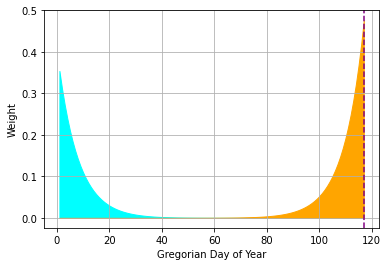

In [56]:
scaling_factor = 0.13
breakup_day_of_year = 117
vals = np.arange(1, breakup_day_of_year+1)

func_right_skew = ((np.exp(-1*scaling_factor*(vals - breakup_day_of_year)))-1)/10000000
func_left_skew = np.exp(scaling_factor*(vals - breakup_day_of_year))/2.1

plt.fill_between(vals, func_right_skew, edgecolor = 'black', color = 'cyan')
plt.fill_between(vals, func_left_skew, edgecolor = 'black', color = 'orange')
plt.axvline(117, linestyle='dashed', color = 'purple')
plt.grid()
plt.xlabel('Gregorian Day of Year')
plt.ylabel('Weight');
plt.savefig('/mnt/locutus/remotesensing/r62/river_ice_breakup/Images/AR_Images/example_weight_curves.png', dpi = 350)

# Test the script

### Plot of change in min temp and max temp, over time, given AR, for all locations

In [11]:
def find_smallest_df(list_of_dfs):
    df_lens = []
    for df in list_of_dfs:
        df_lens.append(len(df))
    df_lens = np.array(df_lens)
    return np.min(df_lens)

In [12]:
os.chdir('/mnt/locutus/remotesensing/r62/river_ice_breakup/atmospheric_rivers/Results/outputs/exponential/')
window_range = list(range(1, 15)) # days

tmins, tmaxes = [], []

for test_pkl in [test_pkl for test_pkl in os.listdir() if test_pkl.startswith('Precip')]:
    test_pkl = read_pickle(f'./{test_pkl}')
    list_before_after_avgs = test_pkl['avg_before_after']
    
    shortest_n = find_smallest_df(list_before_after_avgs)
    
    # make each windowed df the same length
    list_before_after_avgs = [i.iloc[:shortest_n] for i in list_before_after_avgs]

    np_array_avgs = np.stack(list_before_after_avgs)

    tmins_diff = np_array_avgs[:, :, 3] - np_array_avgs[:, :, 0]
    tmaxes_diff = np_array_avgs[:, :, 4] - np_array_avgs[:, :, 1]

    tmins_diff = tmins_diff.T
    tmaxes_diff = tmaxes_diff.T
    
    tmins.append(tmins_diff)
    tmaxes.append(tmaxes_diff)
    
tmins = np.concatenate(tmins)
tmaxes = np.concatenate(tmaxes)

avg_tmins = np.nanmean(tmins, axis = 0)
avg_tmaxes = np.nanmean(tmaxes, axis = 0)

perc_25_tmins = np.percentile(tmins, 25, axis = 0)
perc_75_tmins = np.percentile(tmins, 75, axis = 0)

perc_25_tmaxes = np.percentile(tmaxes, 25, axis = 0)
perc_75_tmaxes = np.percentile(tmaxes, 75, axis = 0)

## Create table of Pearson Corr Coefficients

In [13]:
Pearson_corr_df = pd.DataFrame()

tmin_cols = [f'tmin_{i}' for i in range(1, 15)]
tmaxes_cols = [f'tmax_{i}' for i in range(1, 15)]
tmin_cols.extend(tmaxes_cols)
tmins_tmaxes_pvalues = []

for VAR in ['Precip', 'IVT', 'prcp-IVT']:
    column = []
    FILES = [FILE for FILE in os.listdir() if FILE.startswith(VAR)]
    FILES.sort()
    gregorian_doy = []
    metrics = []      
        
    for FILE in FILES:
        pkl_data = read_pickle(FILE)
        # Also populate the tmin_tmax_pvalues df
        if VAR == 'Precip':
            t_pvalues = np.concatenate([np.array(pkl_data['pvalues_tmin']), np.array(pkl_data['pvalues_tmax'])])
            tmins_tmaxes_pvalues.append(t_pvalues)
        
        pearson_corr = pearsonr(pkl_data['day_of_year'], pkl_data['metrics'])[0]
        pearson_corr = round(pearson_corr, ROUND_TO)
        column.append(pearson_corr)
        
    Pearson_corr_df[VAR] = column
        
locations = [(' ').join(FILE.split('_')[1:]) for FILE in FILES ]
locations = [location.split('.')[0] for location in locations]


tmins_tmaxes_pvalues = pd.DataFrame(np.stack(tmins_tmaxes_pvalues))
Pearson_corr_df['Location'] = locations
tmins_tmaxes_pvalues.columns = tmin_cols
tmins_tmaxes_pvalues['Location'] = locations
tmins_tmaxes_pvalues.set_index('Location', inplace=True)

tmins = tmins_tmaxes_pvalues.iloc[:, :14]
tmaxes = tmins_tmaxes_pvalues.iloc[:, 14:]

Pearson_corr_df.set_index('Location', drop = True, inplace = True)
Pearson_corr_df

,Precip,IVT,prcp-IVT
Location,,,
Akiak Kuskokwim River,-0.78,-0.78,-0.80
Allakaket Koyukuk River,-0.81,-0.66,-0.80
Ambler Kobuk River,-0.84,-0.67,-0.83
Aniak Kuskokwim River,-0.80,-0.81,-0.77
Bethel Kuskokwim River,-0.72,-0.75,-0.73
Bettles Koyukuk River,-0.78,-0.62,-0.81
Circle Yukon River,-0.75,-0.76,-0.74
Crooked Creek Kuskokwim River,-0.84,-0.76,-0.80
Dawson Yukon River,-0.72,-0.67,-0.70


## Plotting relationship of tmin and tamx change with ARs

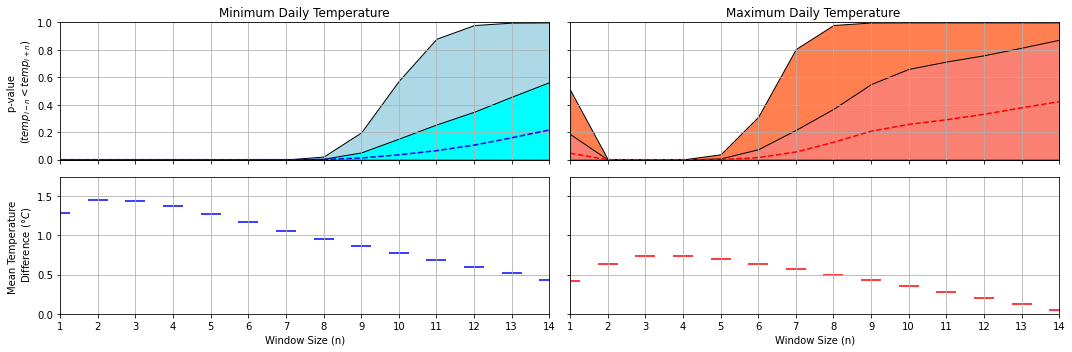

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(15, 5), sharey = 'row', sharex = 'col')

means = []
stds = []
mins = []
maxes = []

for window in np.arange(1, 15):
    
    window_values = np.array(tmins.iloc[:, window-1])
    means.append(np.mean(window_values))
    stds.append(np.std(window_values))
    mins.append(np.min(window_values))
    maxes.append(np.max(window_values))
    
means = np.array(means)
stds = np.array(stds)
mins = np.array(mins)
maxes = np.array(maxes)

axes[0, 0].plot(window_range, means, color = 'blue', linestyle = 'dashed')
axes[0, 0].fill_between(window_range, mins, maxes, color = 'lightblue', edgecolors = 'black')
axes[0, 0].fill_between(window_range, means + stds, mins, color = 'cyan', edgecolors = 'black')

axes[0, 0].set_title(f'Minimum Daily Temperature')
axes[0, 0].set_ylabel(f'p-value \n' + r'($temp_{i-n} < temp_{i+n})$')
axes[0, 0].grid()
axes[0, 0].set_xlim((1, 14))
axes[0, 0].set_ylim((0, 1))

means = []
stds = []
mins = []
maxes = []

for window in np.arange(1, 15):
    
    window_values = np.array(tmaxes.iloc[:, window-1])
    means.append(np.mean(window_values))
    stds.append(np.std(window_values))
    mins.append(np.min(window_values))
    maxes.append(np.max(window_values))
    
means = np.array(means)
stds = np.array(stds)
mins = np.array(mins)
maxes = np.array(maxes)

axes[0, 1].plot(window_range, means, color = 'red', linestyle = 'dashed')
axes[0, 1].fill_between(window_range, mins, maxes, color = 'coral', edgecolors = 'black')
axes[0, 1].fill_between(window_range, means + stds, mins, color = 'salmon', edgecolors = 'black')

axes[0, 1].set_title(f'Maximum Daily Temperature ')
axes[0, 1].set_xlim((1, 14))
axes[0, 1].set_ylim((0, 1))
axes[0, 1].grid()

axes[1, 0].scatter(window_range, avg_tmins, color = 'blue', linestyle = 'solid', marker = "_", s=400)
# axes[1, 0].fill_between(window_range, perc_25_tmins, perc_75_tmins, color = 'lightblue', edgecolors = 'black')
axes[1, 0].set_xlabel('Window Size (n)')
axes[1, 0].set_xticks(window_range)
axes[1, 0].set_ylabel('Mean Temperature \n Difference ($\u00b0C$)')
axes[1, 0].set_ylim((0, 1.75))
axes[1, 0].grid()

axes[1, 1].scatter(window_range, avg_tmaxes, color = 'red', linestyle = 'solid', marker = "_", s=400)
# axes[1, 1].fill_between(window_range, perc_25_tmins, perc_75_tmins, color = 'coral', edgecolors = 'black')
axes[1, 1].set_xlabel('Window Size (n)')
axes[1, 1].set_xticks(window_range)
axes[1, 1].grid()

plt.subplots_adjust(hspace=0.15, wspace=0.05)
plt.tight_layout()
plt.savefig('/mnt/locutus/remotesensing/r62/river_ice_breakup/atmospheric_rivers/Results/images/tmin_vs_tmax_subplots.png', dpi = 350, facecolor = 'white');

## How much of precip is AR and what is the future trend?

In [15]:
os.chdir('/mnt/locutus/remotesensing/r62/river_ice_breakup/atmospheric_rivers/Results/outputs/exponential/')
pkls = [i for i in os.listdir() if i.startswith('Precip')]
data = []

for pkl in pkls:

    df = read_pickle(pkl)
    name = ('_').join(pkl.split('_')[1:-1])
    KIVT = df['df'][['KIVT', 'prcp (mm/day)']]
    KIVT.rename(columns = {'KIVT' : f'{name}_KIVT', 'prcp (mm/day)' : f'{name}_precip'}, inplace = True)
    data.append(KIVT)
    
data = pd.concat(data, axis = 1)
data_cols = data.columns

IVT_cols = [i for i in data_cols if i.endswith('KIVT')]
Precip_cols = [i for i in data_cols if i.endswith('precip')]

/home/r62/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:5034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [16]:
precip_ARs_only = []
total_precip = []
total_perc_ARs_by_location = []
annual_perc_ARs_by_location = []
masks = []

for ivt_col, precip_col in zip(IVT_cols, Precip_cols):
    
    # creating pd.Series for precip and ivt using data above
    ivt_vect = data[ivt_col]
    precip_vect = data[precip_col]
    
    # adding nans to precip vector where ivt == 0.0
    precip_vect_only_ARs = copy.deepcopy(precip_vect)
    # create and append AR mask
    mask = ivt_vect != 0.0
    masks.append(mask)
    precip_vect_only_ARs[~mask] = np.nan
    
    # appending for later
    precip_ARs_only.append(precip_vect_only_ARs)
    total_precip.append(precip_vect)
    
    # Also appending total precip percentage by location
    perc_ars = precip_vect_only_ARs.sum()/precip_vect.sum()
    total_perc_ARs_by_location.append(perc_ars)
    
    # for plotting, I'm calculating annual precip that is from ARs, and total annual precip (summed for aggregation)  
    annual_precip = precip_vect.resample('Y').sum()
    annual_precip_from_ARs = precip_vect_only_ARs.resample('Y').sum()
    annual_perc = annual_precip_from_ARs/annual_precip
    annual_perc_ARs_by_location.append(annual_perc)
    
annual_perc_ARs_by_location = pd.concat(annual_perc_ARs_by_location, axis = 1)

monthly_AR_data = data[IVT_cols].sum(axis = 1)
monthly_AR_data = monthly_AR_data.resample('M').sum()

monthly_precip_data = data[Precip_cols].sum(axis = 1)
monthly_precip_data = monthly_precip_data.resample('M').sum()

### How much of Precip. variation is accounted for by ARs

In [17]:
date_idxs = np.concatenate([i.index for i in total_precip])
all_precip = np.concatenate(total_precip)
full_mask = np.concatenate(masks)

precip_not_AR = all_precip[~full_mask]
date_idxs_not_AR = date_idxs[~full_mask]

precip_AR = all_precip[full_mask]
date_idxs_AR = date_idxs[full_mask]

all_precip_df = pd.DataFrame({'precip' : all_precip, 
                              'time' : date_idxs})
all_precip_df = all_precip_df.groupby('time').sum()


precip_not_AR_df = pd.DataFrame({'precip' : precip_not_AR,
                             'time' : date_idxs_not_AR})
precip_not_AR_df = precip_not_AR_df.groupby('time').sum()


precip_AR_df = pd.DataFrame({'precip' : precip_AR,
                             'time' : date_idxs_AR})
precip_AR_df = precip_AR_df.groupby('time').sum()

precip_not_AR_df = precip_not_AR_df.resample('Y').sum()
precip_AR_df = precip_AR_df.resample('Y').sum()
all_precip_df = all_precip_df.resample('Y').sum()

precip_ar_df = pd.DataFrame({'y' : all_precip_df.precip,
                             'x' : precip_AR_df.precip})

coeff: 0.78 intercept: 6742.02 R2: 0.48



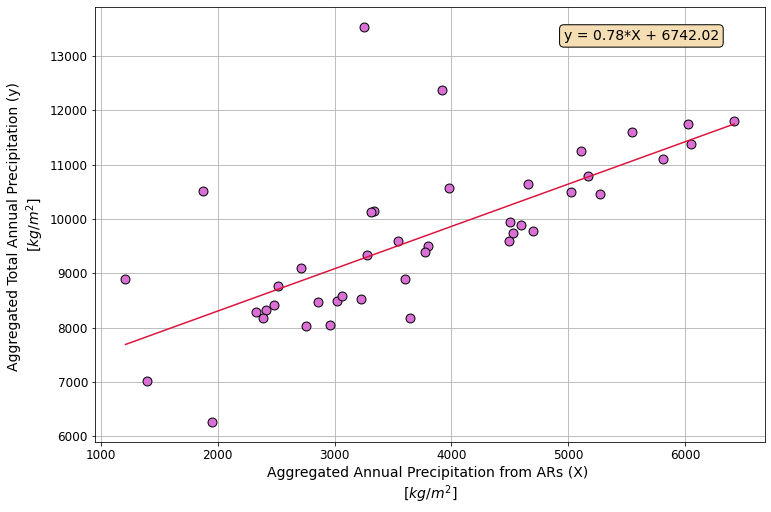

In [90]:
fontsize = 14

model = LinearRegression()
model.fit(precip_ar_df[['x']], precip_ar_df['y'])

r2 = model.score(precip_ar_df[['x']], precip_ar_df['y'])
coefficient = model.coef_
intercept = model.intercept_

r2 = round(float(r2), ROUND_TO)
coefficient = round(float(coefficient), ROUND_TO)
intercept = round(float(intercept), ROUND_TO)

equation = fr"y = {coefficient}*X + {intercept}"


print('coeff:', coefficient, 'intercept:', intercept, 'R2:', r2)
print()

y_values = intercept + coefficient * np.array(precip_ar_df[['x']])
x_values = np.linspace(np.min(np.array(precip_ar_df[['x']])), np.max(np.array(precip_ar_df[['x']])), len(y_values))

fig, axs = plt.subplots(1, 1, figsize=(12, 8))

axs.scatter(precip_ar_df.x,
            precip_ar_df.y,
            color = OTHER_PLOTS_COLOR,
            edgecolor = 'black',
            alpha = 1.0, 
            s = 80,
            zorder = 10)

axs.text(0.70, 0.95, equation, transform=plt.gca().transAxes, fontsize=fontsize,
         verticalalignment='top', horizontalalignment='left',
         bbox=dict(facecolor='wheat', edgecolor='black', boxstyle='round,pad=0.3')  # Box style and color
)

min_x = precip_ar_df[['x']].min()
max_x = precip_ar_df[['x']].max()
min_y = np.min(y_values)
max_y = np.max(y_values)

axs.plot([min_x, max_x],
         [min_y, max_y],
         color = 'crimson',
         zorder = 15)

axs.set_xlabel(f'Aggregated Annual Precipitation from ARs (X) \n' + r'$[kg/m^2]$', fontsize=fontsize)
axs.set_ylabel(f'Aggregated Total Annual Precipitation (y) \n' + r'$[kg/m^2]$', fontsize=fontsize)
axs.tick_params(axis='y', labelsize=fontsize-2)
axs.tick_params(axis='x', labelsize=fontsize-2)

axs.grid()

plt.savefig('/mnt/locutus/remotesensing/r62/river_ice_breakup/atmospheric_rivers/Results/images/AR_Precip_Reg.png',
           facecolor = 'white',
           dpi = 350);

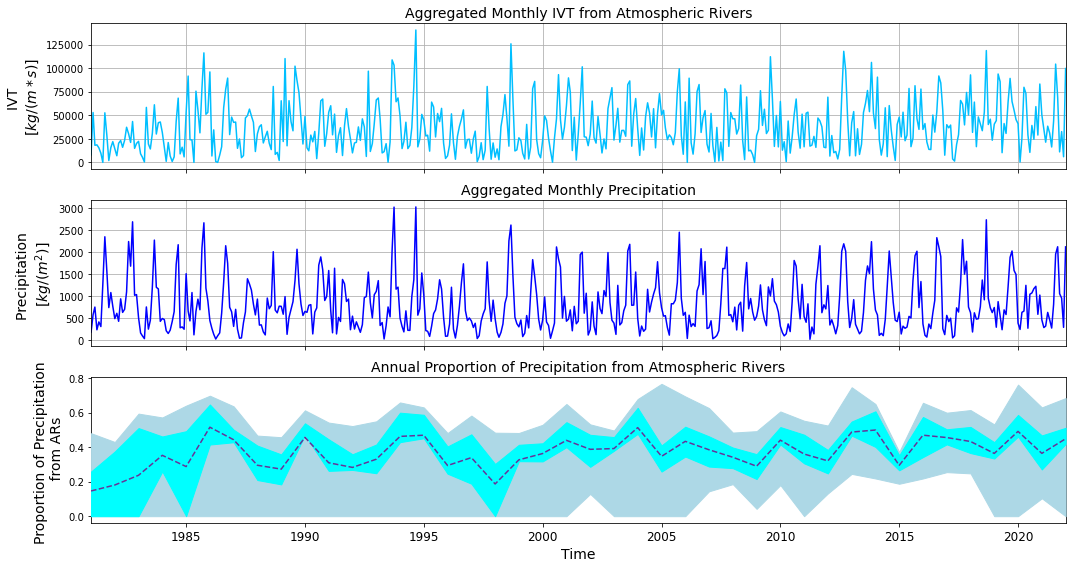

In [91]:
fontsize = 14

fig, axes = plt.subplots(3, 1, figsize=(15, 8), sharey = 'row', sharex = 'col')

axes[0].set_title('Aggregated Monthly IVT from Atmospheric Rivers', fontsize = fontsize)
axes[0].plot(monthly_AR_data.index,
             monthly_AR_data,
             color = AR_COLOR)
axes[0].set_xlim((monthly_AR_data.index[0], monthly_AR_data.index[-1]))
axes[0].set_ylabel('IVT \n' + r'$[kg/(m*s)]$', fontsize = fontsize)
axes[0].grid()


axes[1].set_title('Aggregated Monthly Precipitation', fontsize = fontsize)
axes[1].plot(monthly_precip_data.index,
             monthly_precip_data,
             color = PRECIP_COLOR)
axes[1].set_xlim((monthly_precip_data.index[0], monthly_precip_data.index[-1]))
axes[1].set_ylabel('Precipitation \n' + r'$[kg/(m^2)]$', fontsize = fontsize)
axes[1].tick_params(axis='x', labelsize=fontsize-2)
axes[1].grid()


axes[2].set_title('Annual Proportion of Precipitation from Atmospheric Rivers', fontsize = fontsize)
axes[2].set_ylabel('Proportion of Precipitation \n from ARs', fontsize = fontsize)
axes[2].set_xlabel('Time', fontsize = fontsize)
axes[2].set_xlim((annual_perc_ARs_by_location.index[0], annual_perc_ARs_by_location.index[-1]))
axes[2].tick_params(axis='x', labelsize=fontsize-2)
axes[2].plot(annual_perc_ARs_by_location.index,
         annual_perc_ARs_by_location.mean(axis = 1),
         color = 'rebeccapurple',
         linestyle = 'dashed',
         zorder = 15)

axes[2].fill_between(annual_perc_ARs_by_location.index,
                 annual_perc_ARs_by_location.quantile(0.25, axis = 1),
                 annual_perc_ARs_by_location.quantile(0.75, axis = 1),
                 color = 'cyan',
                 zorder = 10,)

axes[2].fill_between(annual_perc_ARs_by_location.index,
                 annual_perc_ARs_by_location.quantile(0.0, axis = 1),
                 annual_perc_ARs_by_location.quantile(1.0, axis = 1),
                 color = 'lightblue',
                 zorder = 5)

plt.tight_layout()
plt.savefig('/mnt/locutus/remotesensing/r62/river_ice_breakup/atmospheric_rivers/Results/images/IVT_Precip_proportion_over_time.png',
            facecolor = 'white',
            dpi = 350);

### Do ARs tend to cause extreme precip?

In [20]:
mask = np.concatenate(masks)
total_precipitation = np.concatenate(total_precip)

# removing zeros
zeros_mask = total_precipitation != 0.0

total_precipitation = total_precipitation[zeros_mask]
mask = mask[zeros_mask]

precip_from_ARs = total_precipitation[mask]
precip_not_from_ARs = total_precipitation[~mask]

print(' THERE WERE: \n', len(total_precipitation), 'TOTAL PRECIP EVENTS \n', len(precip_from_ARs), 'WERE FROM ARs \n', len(precip_not_from_ARs), 'WERE NOT')

 THERE WERE: 
 105661 TOTAL PRECIP EVENTS 
 29982 WERE FROM ARs 
 75679 WERE NOT


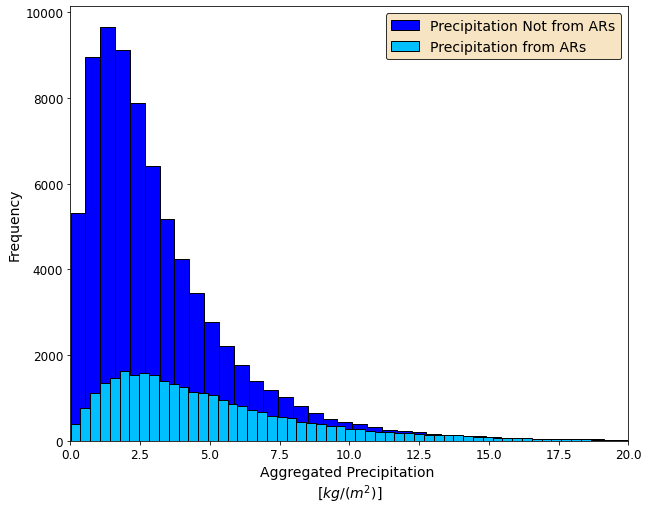

In [10]:
fontsize = 14

fig, axes = plt.subplots(1, 1, figsize=(10, 8))

axes.hist(precip_not_from_ARs,
          200, alpha = 1.0,
          color = PRECIP_COLOR,
          edgecolor = 'black',
          label = 'Precipitation Not from ARs',
          zorder = 5)

axes.hist(precip_from_ARs, 200,
          alpha = 1.0,
          color = AR_COLOR,
          edgecolor = 'black',
          label = 'Precipitation from ARs',
          zorder = 15)

axes.set_ylabel('Frequency', fontsize = fontsize)
axes.set_xlabel('Aggregated Precipitation \n' + r'$[kg/(m^2)]$', fontsize = fontsize)
axes.tick_params(axis='x', labelsize=fontsize-2)
axes.tick_params(axis='y', labelsize=fontsize-2)

axes.set_xlim((0, 20))
axes.legend(fontsize = fontsize,
            facecolor='wheat',
            edgecolor='black',)

plt.savefig('/mnt/locutus/remotesensing/r62/river_ice_breakup/atmospheric_rivers/Results/images/ANOVA_AR_precip_vs_reg_precip.png',
            facecolor = 'white',
            dpi = 350);

/home/r62/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:1708: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/home/r62/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:1708: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


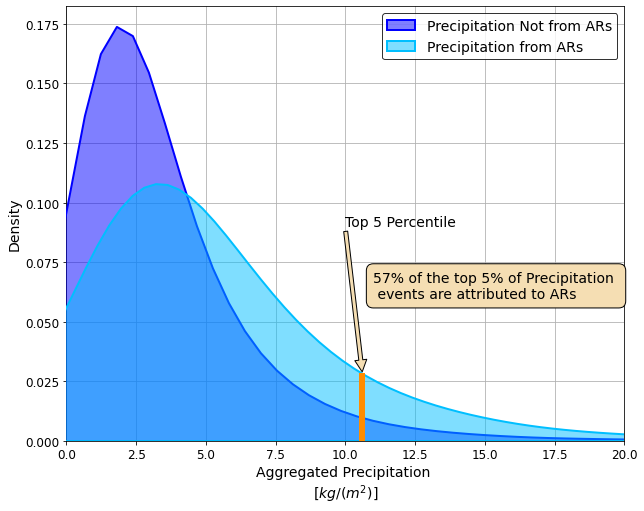

In [21]:
fontsize = 14
bw_adjust = 4
SAVE = True

# Create a figure and axes
fig, ax = plt.subplots(figsize=(10, 8))

sns.kdeplot(data=precip_not_from_ARs,
            ax=ax,
            color=PRECIP_COLOR,
            label='Precipitation Not from ARs',
            linewidth=2,
            zorder=5,
            shade=True,
            alpha = 0.5,
            kernel='epanechnikov',
            bw_adjust=bw_adjust)

second_plot = sns.kdeplot(data=precip_from_ARs,
            ax=ax,
            color=AR_COLOR,
            label='Precipitation from ARs',
            linewidth=2,
            zorder=15,
            shade=True,
            alpha = 0.5,
            kernel='epanechnikov',
            bw_adjust=bw_adjust)


# Set plot labels and ticks
ax.set_ylabel('Density', fontsize=fontsize)
ax.set_xlabel('Aggregated Precipitation \n' + r'$[kg/(m^2)]$', fontsize=fontsize)
ax.tick_params(axis='x', labelsize=fontsize - 2)
ax.tick_params(axis='y', labelsize=fontsize - 2)

# Set x-axis limits
ax.set_xlim((0, 20))

# Annotated section with arrow:
ax.annotate('Top 5 Percentile', xy =(10.6, 0.029),
                xytext =(10, 0.09),
                fontsize=fontsize,
                arrowprops = dict(facecolor ='wheat',))

# to add the yellow line
ax.axvline(10.6, ymin = 0.0,
           ymax = 0.15,
           linewidth = 6,
           color = 'darkorange',
           zorder = 30,
           linestyle = 'solid',)

# Add a textbox to the plot
ax.text(
    x=11,  # X-coordinate for the textbox position
    y=0.06,  # Y-coordinate for the textbox position
    s="57% of the top 5% of Precipitation \n events are attributed to ARs",  # Text content for the textbox
    fontsize=fontsize,  # Font size of the text
    color='black',  # Color of the text
    bbox=dict(facecolor='wheat',
              edgecolor='black',
              boxstyle='round,pad=0.5')
)

# Add legend
ax.legend(fontsize=fontsize,
          facecolor='white',
          edgecolor='black',)

ax.grid()

# Save the figure

if SAVE:
    plt.savefig('/mnt/locutus/remotesensing/r62/river_ice_breakup/atmospheric_rivers/Results/images/ANOVA_AR_precip_vs_reg_precip.png',
                facecolor='white',
                dpi=350)


#### Quick ANOVA showing different dist

In [12]:
alpha = 0.05
root = 4
round_to_int = 6

res_shapiro = shapiro(total_precipitation)
print('SHAPIRO-WILKS TEST FOR NORMALITY')
print('STATISTIC:', round(res_shapiro[0], round_to_int), 'P-VALUE:', round(res_shapiro[1], round_to_int))
print()

res_rank_sum = ranksums(precip_not_from_ARs, precip_from_ARs, alternative='less')
print('WILCOXIN RANK SUM TEST')
print('STATISTIC:', round(res_rank_sum[0], round_to_int), 'P-VALUE:', round(res_rank_sum[1], round_to_int))
print()

res_shapiro = shapiro(total_precipitation**(1/root))
print(f'{root}-ROOT OF PRECIPITATION \n SHAPIRO-WILKS TEST FOR NORMALITY')
print('STATISTIC:', round(res_shapiro[0], round_to_int), 'P-VALUE:', round(res_shapiro[1], round_to_int))
print()

res_ttest = ttest_ind(np.sqrt(precip_not_from_ARs), np.sqrt(precip_from_ARs), alternative='less')
print('SQUARE-ROOT OF PRECIPITATION T-TEST')
print('STATISTIC:', round(res_ttest[0], round_to_int), 'P-VALUE:', round(res_ttest[1], round_to_int))
print()

SHAPIRO-WILKS TEST FOR NORMALITY
STATISTIC: 0.775485 P-VALUE: 0.0

WILCOXIN RANK SUM TEST
STATISTIC: -83.846964 P-VALUE: 0.0

4-ROOT OF PRECIPITATION 
 SHAPIRO-WILKS TEST FOR NORMALITY
STATISTIC: 0.998043 P-VALUE: 0.0

SQUARE-ROOT OF PRECIPITATION T-TEST
STATISTIC: -88.183546 P-VALUE: 0.0



/home/r62/anaconda3/lib/python3.9/site-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [13]:
top_5_percent_mask = total_precipitation >= np.percentile(total_precipitation, 95)
mask = mask[top_5_percent_mask]
total_precipitation = total_precipitation[top_5_percent_mask]
print('PERCENTAGE OF TOP 0.05 PRECIP EVENTS THAT ARE CAUSED BY ARs:', round(mask.sum()/mask.shape[0], 3))

PERCENTAGE OF TOP 0.05 PRECIP EVENTS THAT ARE CAUSED BY ARs: 0.569


## Creating maps for the start of the paper

In [92]:
os.chdir('/mnt/locutus/remotesensing/r62/river_ice_breakup/atmospheric_rivers/daymet/')
src = rasterio.open("./daymet_v4_prcp_annttl_na_2022.tif", 'r')
np_arr = src.read(1)

location_coords = locations_data[locations_data.Site.isin(['Emmonak', 'Mountain Village', 'Russian Mission',
                                  'Holy Cross', 'Kaltag', 'Galena', 'Ruby', 'Tanana',
                                  'Nenana', 'Hughes', 'Allakaket', 'Bettles', 'Ambler', 
                                  'Kobuk', 'Fort Yukon', 'Circle', 'Eagle', 'Dawson',
                                  'Bethel', 'Akiak', 'Aniak', 'Crooked Creek', 'Red Devil',
                                  'McGrath', 'Nikolai'])]

locations = location_coords.Site
points = gpd.GeoDataFrame(location_coords,
                          geometry=gpd.points_from_xy(location_coords.Longitude, location_coords.Latitude),
                          crs="EPSG:4326")

In [93]:
from rasterio.transform import rowcol
from rasterio.plot import show
from rasterio.features import rasterize

# Load the raster file
raster_file = './daymet_v4_prcp_annttl_na_2022.tif'

row_indices, col_indices = [], []

with rasterio.open(raster_file) as src:
    # Get raster information
    transform = src.transform
    width, height = src.width, src.height
    crs = src.crs
    
    # Create an empty mask array (initialize with 0s)
    mask_array = np.zeros((height, width), dtype=np.uint8)
    
    # Transform points to the raster CRS if necessary
    if points.crs != crs:
        points = points.to_crs(crs)
    
    # Iterate through the points and set mask values
    for index, row in points.iterrows():
        # Get the coordinates
        x, y = row.geometry.x, row.geometry.y
        
        # Convert coordinates to pixel indices
        col, row = rowcol(transform, x, y)
        
        # Set mask value to 1 (point)
        if 0 <= col < width and 0 <= row < height:
            mask_array[row, col] = 1
            row_indices.append(row)
            col_indices.append(col)
            
    # Save the mask array as a new GeoTIFF
    mask_file = 'mask_layer.tif'
    with rasterio.open(mask_file, 'w', driver='GTiff', height=height, width=width, count=1,
                       dtype=mask_array.dtype, crs=crs, transform=transform) as dst:
        dst.write(mask_array, 1)

new_src = rasterio.open('./mask_layer.tif')
points_raster = new_src.read(1)

points_raster = points_raster.astype('float32')
points_raster[points_raster == 0] = np.nan

# row_indices, col_indices = np.where(points_raster == 1)

ERROR 1: PROJ: proj_create_from_name: /home/r62/anaconda3/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 0 whereas a number >= 2 is expected. It comes from another PROJ installation.


In [38]:
# The North American Daymet projection system and parameters:

# Projection System: Lambert Conformal Conic
# Parameters:
# projection units: meters
# datum (spheroid): WGS_84
# 1st standard parallel: 25 deg N
# 2nd standard parallel: 60 deg N
# Central meridian: -100 deg (W)
# Latitude of origin: 42.5 deg N
# false easting: 0
# false northing: 0
# The spatial resolution of the Daymet gridded dataset is 1 km.

os.chdir('/mnt/locutus/remotesensing/r62/river_ice_breakup/atmospheric_rivers/daymet/')

# Import and process Precip daymet_v4_prcp_annttl_na_2022.tif

src = rasterio.open("./daymet_v4_prcp_annttl_na_2022.tif", 'r')
np_arr = src.read(1)

lats = locations_data['Latitude']
lons = locations_data['Longitude']
points = [(i, j) for i, j in zip(np.array(lats), np.array(lons))]

In [77]:

def transform_raster_to_epsg(input_raster_path, output_raster_path, epsg='4326'):
    """
    Transforms a raster from Lambert Conformal Conic projection to EPSG:4326.
    
    Parameters:
        input_raster_path (str): Path to the input raster file.
        output_raster_path (str): Path to the output raster file in EPSG:4326.
    """
    
    from osgeo import gdal

    # Define the target CRS (EPSG:4326)
    target_crs = f"EPSG:{epsg}"
    
    # Define the gdalwarp options
    warp_options = gdal.WarpOptions(dstSRS=target_crs, resampleAlg='near')
    
    # Open the input raster file
    input_raster = gdal.Open(input_raster_path)
    
    # Use gdal.Warp to reproject the raster
    gdal.Warp(output_raster_path, input_raster, options=warp_options)
    
    # Close the input raster file
    input_raster = None
    
    print(f"Raster transformed and saved to {output_raster_path}")

# Example usage
# input_raster_path = 'path_to_input_raster.tif'  # Path to your input raster file
# output_raster_path = 'path_to_output_raster.tif'  # Path to save the output raster file

# transform_raster_to_epsg4326(input_raster_path, output_raster_path)

In [138]:
x_0 = 0
y_0=0
lat_0=42.5
lon_0=-100
lat_1=25
lat_2=60
new_proj='lcc'
datum='WGS84'
source_proj = 'epsg:4326'
bbox = (-173.0, 51.0, -129.0, 72.0)
points = [(i, j) for i, j in zip(np.array(lats), np.array(lons))]

In [139]:
from pyproj import Proj, Transformer

# Define the source projection (EPSG:4326 - WGS 84)
source_proj = Proj('epsg:4326')

# Define the target projection (Lambert Conformal Conic) based on your parameters
target_proj = Proj(proj='lcc', datum='WGS84',
                   lat_1=25, lat_2=60,
                   lat_0=42.5, lon_0=-100,
                   x_0=0, y_0=0,
                   units='m')

# Create a transformer
transformer = Transformer.from_proj(source_proj, target_proj)

# Transform the points
points = [transformer.transform(lat, lon) for lat, lon in points]

# Transform the points
trans_bbox = [transformer.transform(lat, lon) for lat, lon in [(20.0, -170.0), (100.0, -80.0)]]

In [81]:
da = xr.open_rasterio("./daymet_v4_prcp_annttl_na_2022.tif")
transform = Affine.from_gdal(*da.attrs['transform']) # this is important to retain the geographic attributes from the file

AttributeError: module 'xarray' has no attribute 'open_rasterio'

In [93]:
# Plot!
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111, projection=src.crs)
ax.coastlines(resolution='1000m', alpha=0.1)
ax.contourf(x, y, da.variable.data[0], cmap='Greys')
ax.set_extent([lon_min, lon_max, lat_min, lat_max])
# Grid and Labels
gl = ax.gridlines(crs=crs, draw_labels=True, alpha=0.5)
gl.xlabels_top = None
gl.ylabels_right = None
xgrid = np.arange(lon_min-0.5, lon_max+0.5, 1.)
ygrid = np.arange(lat_min, lat_max+1, 1.)
gl.xlocator = mticker.FixedLocator(xgrid.tolist())
gl.ylocator = mticker.FixedLocator(ygrid.tolist())
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 14, 'color': 'black'}
gl.ylabel_style = {'size': 14, 'color': 'black'}
plt.show()

NameError: name 'show' is not defined

In [105]:
lat=[]
lon=[]
for i in transformed_points:
    lat.append(i[0])
    lon.append(i[1])

In [107]:
import geopandas as gpd

updated_points = gpd.points_from_xy(x=lon, y=lat)
gdf = gpd.GeoDataFrame(geometry=transformed_points)

TypeError: Input must be valid geometry objects: (-3048893.5677962922, 3157359.9540587636)

In [108]:
src.read(1).shape

(8075, 7814)

In [109]:
temp_arr = np.zeros((8075, 7814))

In [112]:
for i, j in zip(lat, lon):
    temp_arr[int(i), int(j)] = 1

IndexError: index -3048893 is out of bounds for axis 0 with size 8075

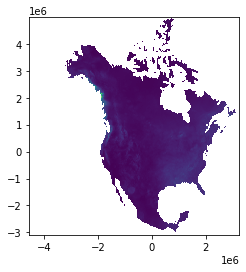

AttributeError: module 'geopandas' has no attribute 'plot'

In [100]:
rasterio.plot.show(src)
gdf.plot(marker='o', color='red', markersize=50)

In [90]:
trans_bbox = np.array(trans_bbox).flatten() # (min_latitude, min_longitude, max_latitude, max_longitude).

In [91]:
trans_bbox # [trans_bbox[1], trans_bbox[0], trans_bbox[2], trans_bbox[3]]

array([-6683528.46626635,   537518.24742565,               inf,
                     inf])

In [92]:
clipped_raster = clip_raster(src=src, bbox=trans_bbox, output_path=None)

ValueError: cannot convert float NaN to integer

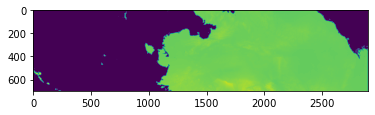

In [85]:
plt.imshow(np.squeeze(clipped_raster));

In [20]:
import rasterio
import geopandas as gpd
from rasterio.mask import mask
from shapely.geometry import box


def transform_points(lats,
                         lons,
                         source_proj,
                         new_proj,
                         datum,
                         lat_1,
                         lat_2,
                         lat_0,
                         lon_0,
                         x_0,
                         y_0,
                         units = 'm'):

    '''
    lats and lons can be pd.Series, lists, np.arrays
    source_proj: for example 'epsg:4326'
    new_proj: 'lcc' (for Lambert Conformal Conic)

    '''

    points = [(i, j) for i, j in zip(np.array(lats), np.array(lons))]

    from pyproj import Proj, Transformer
    source_proj = Proj(source_proj)

    # Define the target projection (Lambert Conformal Conic) based on your parameters
    target_proj = Proj(new_proj=new_proj, datum=datum,
                       lat_1=lat_1, lat_2=lat_2,
                       lat_0=lat_0, lon_0=lon_0,
                       x_0=x_0, y_0=y_0,
                       units=units)
    # Create a transformer
    transformer = Transformer.from_proj(source_proj, target_proj)

    # Transform the points
    return [transformer.transform(lat, lon) for lat, lon in points]

def clip_raster(src, bbox, output_path=None):
    """
    Clips a raster based on a bounding box and saves the result to the output file path.
    
    Parameters:
        raster_path (str): The file path to the input raster.
        bbox (tuple): A tuple containing four elements (min_x, min_y, max_x, max_y) defining the bounding box.
        output_path (str): The file path to save the clipped raster. If None, the function will return the clipped raster data.
    
    Returns:
        If output_path is None, returns the clipped raster data as a numpy array.
    """
    
    min_x, min_y, max_x, max_y = bbox
    bbox_polygon = box(min_x, min_y, max_x, max_y)
    
    if type(src) == rasterio.io.DatasetReader:
        src
    elif type(src) == str:
        src = rasterio.open(raster_path)
        
    # Open the raster file
    # with rasterio.open(raster_path) as src:
        
    # Create a GeoDataFrame with the bounding box polygon
    gdf = gpd.GeoDataFrame({'geometry': [bbox_polygon]}, crs=src.crs)

    # Clip the raster using the bounding box
    clipped_raster, transform = mask(src, [bbox_polygon], crop=True)

    # If output path is provided, save the clipped raster
    if output_path:
        with rasterio.open(
            output_path,
            'w',
            driver='GTiff',
            height=clipped_raster.shape[1],
            width=clipped_raster.shape[2],
            count=clipped_raster.shape[0],
            dtype=clipped_raster.dtype,
            crs=src.crs,
            transform=transform,
        ) as dst:
            dst.write(clipped_raster)
    else:
        return clipped_raster


In [34]:
coords_for_bbox = transform_points([51.0, 72.0],
                     [-173.0, -129.0],
                     source_proj,
                     new_proj,
                     datum,
                     lat_1,
                     lat_2,
                     lat_0,
                     lon_0,
                     x_0,
                     y_0,
                     units = 'm')

CRSError: Invalid projection: +new_proj=lcc +datum=WGS84 +lat_1=25 +lat_2=60 +lat_0=42.5 +lon_0=-100 +x_0=0 +y_0=0 +units=m +type=crs: (Internal Proj Error: proj_create: unrecognized format / unknown name)

In [ ]:
# Example usage
raster_path = 'path_to_raster.tif'
bbox = (min_x, min_y, max_x, max_y)  # Define your bounding box here
output_path = 'path_to_output.tif'

# Call the function to clip the raster and save the result
clip_raster(raster_path, bbox, output_path)


In [21]:
lats = locations_data['Latitude']
lons = locations_data['Longitude']
points = [(i, j) for i, j in zip(np.array(lats), np.array(lons))]

In [23]:
x_0 = 0
y_0=0
lat_0=42.5
lon_0=-100
lat_1=25
lat_2=60
proj='lcc'
datum='WGS84'
source_proj = 'epsg:4326'
bbox = (-173.0, 51.0, -129.0, 72.0)


In [26]:
transformed_points

NameError: name 'transformed_points' is not defined

In [94]:
# clip it to fit AK
# np_arr_prcp = np_arr[850:2500, 1100:3000]
np_arr_prcp = np_arr
# replace -9999.0 with np.NaN
np_arr_prcp[np_arr_prcp == -9999.0] = np.nan

# Remove the extremes
np_arr_prcp[np_arr_prcp >= 2000] = np.nan

# Import and process Tmin daymet_v4_tmin_annavg_na_2022.tif
src = rasterio.open("./daymet_v4_tmin_annavg_na_2022.tif")
np_arr_tmin = src.read(1)

# clip it to fit AK
# np_arr_tmin = np_arr_tmin[850:2500, 1100:3000]

# replace -9999.0 with np.NaN
np_arr_tmin[np_arr_tmin == -9999.0] = np.nan

from matplotlib.colors import ListedColormap

cool_cmap = plt.cm.get_cmap('Blues') 
cool_cmap = cool_cmap.reversed()

gist_earth_cmap = plt.cm.get_cmap('gist_earth') 
gist_earth_cmap = gist_earth_cmap.reversed()

spectral_cmap = plt.cm.get_cmap('Spectral') 
spectral_cmap = spectral_cmap.reversed()

spectral_cmap = spectral_cmap(np.linspace(0, 0.75, 256))

# Create a new custom ListedColormap using the subset of colors
spectral_cmap = ListedColormap(spectral_cmap)

In [95]:
def annotate_scatter_plot(points_x, points_y, labels, ax, fontsize=10):
    for idx, label in enumerate(labels):
        if label not in ['Hughes', 'Galena', 'Holy Cross', 'McGrath',
                         'Red Devil', 'Allakaket', 'Akiak', 'Bethel', 'Nikolai']:
            ax.text(points_x[idx], points_y[idx], '  ' + label, fontsize = fontsize)

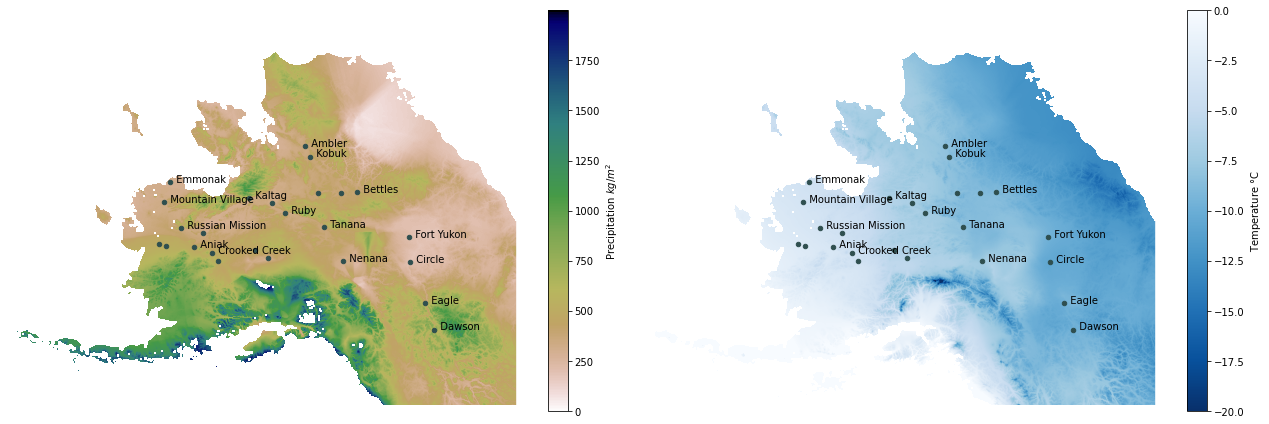

In [97]:
fig, axs = plt.subplots(1, 2, figsize = (18, 6)) # the ratio here must be 3:1

plot_axs1 = axs[0].imshow(np_arr_prcp,
                          cmap = gist_earth_cmap)
axs[0].set_xticks([])
axs[0].set_yticks([])

axs[0].scatter(row_indices, col_indices, color = 'darkslategrey', marker = "o", s=20)
annotate_scatter_plot(row_indices,
                      col_indices,
                      locations,
                      ax=axs[0])

axs[0].set_xlim((850, 3000))
axs[0].set_ylim((2500, 850))

color_bar_1 = fig.colorbar(plot_axs1,
                           ax=axs[0],
                           orientation='vertical')

color_bar_1.set_label('Precipitation ' + r'$kg/m^2$')

plot_axs2 = axs[1].imshow(np_arr_tmin,
                          cmap = cool_cmap,
                          vmin = -20, vmax = 0)
axs[1].set_xticks([])
axs[1].set_yticks([])
color_bar_2 = fig.colorbar(plot_axs2,
                            ax=axs[1],
                            orientation='vertical')

color_bar_2.set_label('Temperature ' + u'$\u00b0$C')

# This removes the outer edge lines
for ax in axs:
    ax.spines['top'].set_edgecolor('white')
    ax.spines['bottom'].set_edgecolor('white')
    ax.spines['left'].set_edgecolor('white')
    ax.spines['right'].set_edgecolor('white')

axs[1].scatter(row_indices, col_indices, color = 'darkslategrey', marker = "o", s=20)
annotate_scatter_plot(row_indices,
                      col_indices,
                      locations,
                      ax=axs[1])

axs[1].set_xlim((850, 3000))
axs[1].set_ylim((2500, 850))

plt.subplots_adjust(wspace=0, hspace=0)
plt.tight_layout();

plt.savefig('/mnt/locutus/remotesensing/r62/river_ice_breakup/atmospheric_rivers/Results/images/maps_precip_temp.png',
           dpi = 400,
           facecolor='white')

In [178]:
from osgeo import ogr

pointX = -161.211508 
pointY = 60.912732

# Spatial Reference System
inputEPSG = 4326
outputEPSG = 9122

# create a geometry from coordinates
point = ogr.Geometry(ogr.wkbPoint)
point.AddPoint(pointX, pointY)

# create coordinate transformation
inSpatialRef = osr.SpatialReference()
inSpatialRef.ImportFromEPSG(inputEPSG)

outSpatialRef = osr.SpatialReference()
outSpatialRef.ImportFromEPSG(outputEPSG)

coordTransform = osr.CoordinateTransformation(inSpatialRef, outSpatialRef)

# transform point
point.Transform(coordTransform)

print(coordTransform)

# print point in EPSG 9122
print(point.GetX(), point.GetY())

ModuleNotFoundError: No module named 'osgeo'

In [158]:
import earthpy.plot as ep
ep.plot_bands()

KeyboardInterrupt: 

In [147]:
points_data[points_data.Site == 'Bethel']

,Site,Latitude,Longitude
7,Bethel,60.765796,198.250559


In [157]:
src.crs

ERROR 1: PROJ: proj_identify: /home/r62/anaconda3/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 0 whereas a number >= 2 is expected. It comes from another PROJ installation.


CRS.from_wkt('PROJCS["unnamed",GEOGCS["unknown",DATUM["unknown",SPHEROID["Spheroid",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Lambert_Conformal_Conic_2SP"],PARAMETER["latitude_of_origin",42.5],PARAMETER["central_meridian",-100],PARAMETER["standard_parallel_1",25],PARAMETER["standard_parallel_2",60],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]')

In [153]:
420/198.250559

2.118531226940954

In [150]:
1200/60.765796

19.747951627260836

In [154]:
lats = points_data['Latitude']*19.747951627260836
lons = points_data['Longitude']*2.118531226940954

In [152]:
lats

0     1202.901586
1     1237.572292
2     1314.551973
3     1324.940856
4     1216.227700
5     1237.204407
6     1310.344139
7     1199.999901
8     1321.565339
9     1299.746678
10    1221.725292
11    1264.973797
12    1279.360020
13    1239.606962
14    1280.210051
15    1314.537261
16    1230.265017
17    1230.213633
18    1278.298173
19    1228.575343
20    1304.222847
21    1215.196857
22    1270.347273
23    1321.339225
24    1282.991905
25    1222.083421
26    1243.357987
27    1225.919698
28    1274.839477
29    1244.353481
30    1243.738865
31    1220.204661
32    1278.539295
33    1219.947068
34    1320.816714
35    1218.527527
36    1303.410180
37    1220.159142
38    1227.287065
39    1286.965272
Name: Latitude, dtype: float64

AttributeError: 'DatasetReader' object has no attribute 'plot'

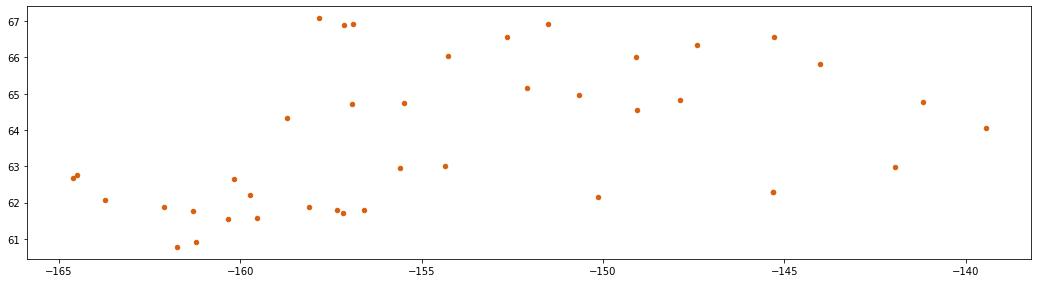

In [80]:
fig, axs = plt.subplots(1, 1, figsize = (18, 6))
gdf_points.plot(ax=axs, color='#d95f0e', marker='o', markersize=20, label='Point', zorder = 10)
src.plot()

# Old Statistical Analysis

### ANOVA

In [64]:
yes_AR = np.array(all_74_breakup_doys[mask])
no_AR = np.array(all_74_breakup_doys[~mask])

alpha = 0.05

res_shapiro = shapiro(np.array(all_74_breakup_doys))
print('SHAPIRO-WILKS TEST FOR NORMALITY')
print('STATISTIC:', round(res_shapiro[0], 3), 'P-VALUE:', round(res_shapiro[1], 3))
print()

if res_shapiro[1] <= alpha:

    print('DATA IS NOT NORMALLY DISTRIBUTED PROCEEDING WITH WILCOXIN RANK SUM TEST')
    print()
    res_ts = ranksums(x = yes_AR, y = no_AR, alternative='two-sided')
    res_less = ranksums(x = yes_AR, y = no_AR, alternative='less')
    res_greater = ranksums(x = yes_AR, y = no_AR, alternative='greater')

    print('TWO-SIDED TEST STATISTIC:', round(res_ts[0], 3), 'P-VALUE:', round(res_ts[1], 3))
    print('X < Y TEST STATISTIC:', round(res_less[0], 3), 'P-VALUE:', round(res_less[1], 3))
    print('X > Y TEST STATISTIC:', round(res_greater[0], 3), 'P-VALUE:', round(res_greater[1], 3))
    
else:
    
    print('DATA IS NORMALLY DISTRIBUTED PROCEEDING WITH STUDENT T-TEST AND WELCHS T-TEST')
    print()
    res_student_T_two_sided = ttest_ind(yes_AR, no_AR, equal_var = True, alternative = 'two-sided')
    res_student_T_less = ttest_ind(yes_AR, no_AR, equal_var = True, alternative = 'less')
    res_student_T_greater = ttest_ind(yes_AR, no_AR, equal_var = True, alternative = 'greater')
    
    res_welchs_T_two_sided = ttest_ind(yes_AR, no_AR, equal_var = False, alternative = 'two-sided')
    res_welchs_T_less = ttest_ind(yes_AR, no_AR, equal_var = False, alternative = 'less')
    res_welchs_T_greater = ttest_ind(yes_AR, no_AR, equal_var = False, alternative = 'greater')

    print('TWO-SIDED STUDENT T-TEST STATISTIC:', round(res_student_T_two_sided[0], 3), 'P-VALUE:', round(res_student_T_two_sided[1], 3))
    print('X < Y STUDENT T-TEST STATISTIC:', round(res_student_T_less[0], 3), 'P-VALUE:', round(res_student_T_less[1], 3))
    print('X > Y STUDENT T-TEST STATISTIC:', round(res_student_T_greater[0], 3), 'P-VALUE:', round(res_student_T_greater[1], 3))
    print()
    print('TWO-SIDED WELCHS T-TEST STATISTIC:', round(res_welchs_T_two_sided[0], 3), 'P-VALUE:', round(res_welchs_T_two_sided[1], 3))
    print('X < Y WELCHS T-TEST STATISTIC:', round(res_welchs_T_less[0], 3), 'P-VALUE:', round(res_welchs_T_less[1], 3))
    print('X > Y WELCHS T-TEST STATISTIC:', round(res_welchs_T_greater[0], 3), 'P-VALUE:', round(res_welchs_T_greater[1], 3))

SHAPIRO-WILKS TEST FOR NORMALITY
STATISTIC: 0.974 P-VALUE: 0.527

DATA IS NORMALLY DISTRIBUTED PROCEEDING WITH STUDENT T-TEST AND WELCHS T-TEST

TWO-SIDED STUDENT T-TEST STATISTIC: -0.357 P-VALUE: 0.723
X < Y STUDENT T-TEST STATISTIC: -0.357 P-VALUE: 0.362
X > Y STUDENT T-TEST STATISTIC: -0.357 P-VALUE: 0.638

TWO-SIDED WELCHS T-TEST STATISTIC: -0.36 P-VALUE: 0.721
X < Y WELCHS T-TEST STATISTIC: -0.36 P-VALUE: 0.36
X > Y WELCHS T-TEST STATISTIC: -0.36 P-VALUE: 0.64


### Chi-Squared Test

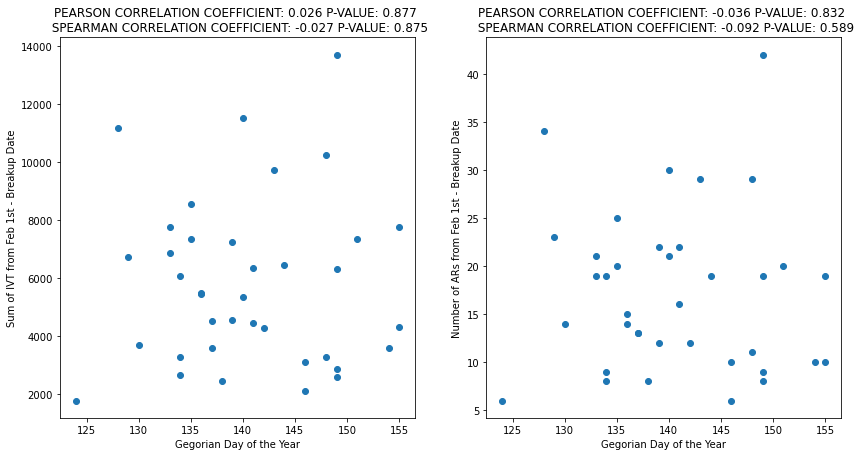

In [65]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize=(14, 7))

axs[0].scatter(all_74_breakup_doys, aggregated_IVT)
axs[0].set_xlabel('Gegorian Day of the Year')

if aggregation_method.upper() == 'SUM':
    axs[0].set_ylabel('Sum of IVT from Feb 1st - Breakup Date')
elif aggregation_method.upper() == 'MEAN_ZEROS':
    axs[0].set_ylabel('Average IVT Among ARs from Feb 1st - Breakup Date')
elif aggregation_method.upper() == 'MEAN_NO_ZEROS':
    axs[0].set_ylabel('Average IVT along all days from Feb 1st - Breakup Date')
    
pearson_res = pearsonr(all_74_breakup_doys, aggregated_IVT)
spearman_res = spearmanr(all_74_breakup_doys, aggregated_IVT)

# print('PEARSON CORRELATION COEFFICIENT:', round(pearson_res[0],3), 'P-VALUE:', round(pearson_res[1], 3) )
# print('SPEARMAN CORRELATION COEFFICIENT:', round(spearman_res[0],3), 'P-VALUE:', round(spearman_res[1], 3))
axs1_title = f'PEARSON CORRELATION COEFFICIENT: {round(pearson_res[0],3)} P-VALUE: {round(pearson_res[1], 3)} \n SPEARMAN CORRELATION COEFFICIENT: {round(spearman_res[0],3)} P-VALUE: {round(spearman_res[1], 3)}'
axs[0].set_title(axs1_title)

axs[1].scatter(all_74_breakup_doys, ns)
axs[1].set_xlabel('Gegorian Day of the Year')
axs[1].set_ylabel('Number of ARs from Feb 1st - Breakup Date')

pearson_res = pearsonr(all_74_breakup_doys, ns)
spearman_res = spearmanr(all_74_breakup_doys, ns)

axs2_title = f'PEARSON CORRELATION COEFFICIENT: {round(pearson_res[0],3)} P-VALUE: {round(pearson_res[1], 3)} \n SPEARMAN CORRELATION COEFFICIENT: {round(spearman_res[0],3)} P-VALUE: {round(spearman_res[1], 3)}'
axs[1].set_title(axs2_title);

# print('PEARSON CORRELATION COEFFICIENT:', round(pearson_res[0],3), 'P-VALUE:', round(pearson_res[1], 3) )
# print('SPEARMAN CORRELATION COEFFICIENT:', round(spearman_res[0],3), 'P-VALUE:', round(spearman_res[1], 3));